Enrico Convento --- id: 2023572

# Regression

In [1]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 7.9 MB/s 
     |████████████████████████████████| 210 kB 41.8 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 113 kB 33.7 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 149 kB 45.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=7c599fdfd39169417cb1cf121b4198d99e2ee72356af3c273c4b0541ae2323fa
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
# from google.colab import files # in order to be able to download and upload files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.model_selection import train_test_split, KFold

import os
from tqdm.notebook import tqdm

import optuna

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # solving a bug of colab.
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}: {torch.cuda.get_device_name(0)}")

Training device: cuda: Tesla K80


# Dataset

In [4]:
# get the datasets

!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv

all_train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

--2022-02-07 18:54:39--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-02-07 18:54:40 (55.7 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-02-07 18:54:40--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regre

In [5]:
class CsvDataset(Dataset):

  def __init__(self, data_df, transform=None):
    '''
    Args:
      data_df: pd.DataFrame object with the data
      transform (callable, optional): Optional transform to be applied on a sample.
    '''
    self.transform = transform
    self.data = data_df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    sample = (row.input, row.label)

    if self.transform:
      sample = self.transform(sample)
    return sample

class ArrayDataset(Dataset):
  '''
  Args:
    data_array: np.array with the data with shape (n_data, 2)
    transform (callable, optional): Optional transform to be applied on a sample.
  '''
  def __init__(self, data_array, transform=None):
    self.transform = transform
    self.data = data_array

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    sample = (self.data[idx,0], self.data[idx,1])
    if self.transform:
      sample = self.transform(sample)
    return sample


class ToTensor(object):
    '''
    Convert sample to Tensors.
    '''
    def __call__(self, sample):
      x,y = sample
      return (torch.tensor([x]).float(), torch.tensor([y]).float())



composed_transform = transforms.Compose([ToTensor()])

all_train_dataset = CsvDataset(all_train_df, transform=composed_transform)
test_dataset   = CsvDataset(test_df, transform=composed_transform)

## Solution 1

In [6]:
class Net(nn.Module):
  def __init__(self, Ni=1, Nh1=None, Nh2=None, No=1, activation_function=nn.Sigmoid(), verbose=False):
    '''
    Network with 2 hidden linear layers
    '''
    super().__init__()
    self.No = No

    self.fc1 = nn.Linear(in_features=Ni,out_features=Nh1)
    self.fc2 = nn.Linear(in_features=Nh1,out_features=Nh2)
    self.out = nn.Linear(in_features=Nh2,out_features=self.No)

    self.act = activation_function

    if verbose:
      print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.out(x)

    return x

In [7]:
class Training(object):
  '''
  Class for training the Network. This class is a starting point: to do more advanced stuff one can define new classes inheriting from this one.

  Args:
    net
    optimizer: needs to be already linked to the net
    loss_function
    train_dataloader: training Dataloader
    val_dataloader: validation Dataloader
  '''
  def __init__(self, net, optimizer, loss_function, train_dataloader, val_dataloader):
    self.net = net
    self.optimizer = optimizer
    self.loss_function = loss_function

    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader

    self.train_loss_log = []
    self.val_loss_log = []

  ## Early stopping
  def stop_learning(self,epoch_num):
    return False


  def train_epoch(self):
    train_loss= []
    self.net.train() # Training mode
    for sample_batched in self.train_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      # set previous gradients to 0
      self.optimizer.zero_grad()
      # Forward pass
      out = self.net(x_batch)
      # Compute loss
      loss = self.loss_function(out,label_batch)
      # Backpropagation
      loss.backward()
      # Update the weights
      self.optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    return train_loss

  def val_epoch(self, dataloader ):
    '''
    Args:
      dl: Dataloader on which to perform the test
    '''
    val_loss= []
    self.net.eval() # Evaluation mode
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = self.net(x_batch)
        # Compute loss
        loss = self.loss_function(out,label_batch)
        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

      # Save average validation loss
      val_loss = np.mean(val_loss)
      return val_loss

  def train(self,num_epochs,verbose=False):

    ### TRAINING LOOP
    for epoch_num in tqdm(range(num_epochs)):
      if verbose:
        print('#################')
        print(f'# EPOCH {epoch_num}')

      ### TRAIN
      train_loss = self.train_epoch()
      if verbose:
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
      self.train_loss_log.append(train_loss)

      if self.val_dataloader != None:
        ### VALIDATION
        val_loss = self.val_epoch(self.val_dataloader)
        if verbose:
          print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        self.val_loss_log.append(val_loss)

        if self.stop_learning(epoch_num):
          break
      
        

  def plot_losses(self,avg_size=10):
    '''
    Plots the behavior of the train and val losses and prints their average in the last 'avg_size' epochs
    Args:
      avg_size: int
    '''
    plt.figure(figsize=(12,8))
    plt.semilogy(self.train_loss_log, label='Training loss')
    plt.semilogy(self.val_loss_log, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

    print('Average traininig  loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.train_loss_log[-avg_size:])))
    print('Average validation loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.val_loss_log[-avg_size:])))


  def test(self,test_dataset):
    '''
    Args:
      test_dataset: Dataset with data on which to perform the test
    '''
    test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)
    return self.val_epoch(test_dataloader)

  def plot(self,train_df=None,val_df=None,test_df=None, xmin=-5,xmax=5, n_fine_points=1000):
    '''
    Plots data and the model output

    Args:
      train_df: optional, pd.DataFrame with the training data
      val_df: optional, pd.DataFrame with the validation data
      test_df: optional, pd.DataFrame with the test data
      xmin: minimum value for the input, default -5
      xmax: maximum value for the input, default 5
      n_fine_points: number of points in which to evaluate the model
    '''
    x_vec = torch.linspace(xmin,xmax,n_fine_points).to(device)
    x_vec = x_vec.unsqueeze(-1)

    self.net.eval()
    with torch.no_grad():
      y_vec = self.net(x_vec)

    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot output
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(x_vec, y_vec, label='Network output')
    if train_df is not None:
      plt.scatter(train_df.input,train_df.label,label='Training points', color='blue')
    if val_df is not None:
      plt.scatter(val_df.input,val_df.label,label='Validation points', color='orange')
    if test_df is not None:
      plt.scatter(test_df.input,test_df.label,label='Test points', color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend()
    plt.show()

    return fig, ax

In [8]:
## TEST ##
Nh1 = 128
Nh2 = 128
activation_function = nn.Sigmoid()

torch.manual_seed(0)

net = Net(Nh1=Nh1, Nh2=Nh2, activation_function=activation_function).to(device)

optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=0)

loss_function = nn.MSELoss()

val_perc = 0.1
train_batch_size = 10

train_df, val_df = train_test_split(all_train_df,test_size=val_perc,shuffle=True)
train_dataloader = DataLoader(CsvDataset(train_df,transform=composed_transform), batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(CsvDataset(val_df,transform=composed_transform), batch_size=len(val_df), shuffle=False, num_workers=0)


net = Training(net=net,optimizer=optimizer,loss_function=loss_function,train_dataloader=train_dataloader,val_dataloader=val_dataloader)

  0%|          | 0/1000 [00:00<?, ?it/s]

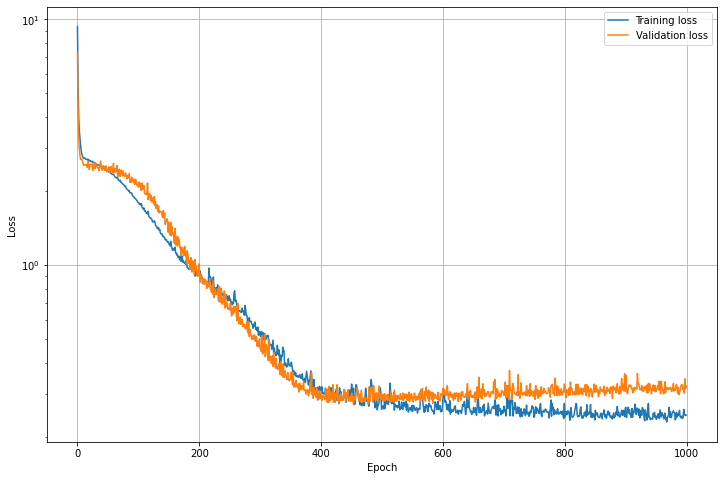

Average traininig  loss in the last 10 epochs: 0.2447
Average validation loss in the last 10 epochs: 0.3208


In [9]:
net.train(1000,verbose= False)
net.plot_losses()


Training solution 1

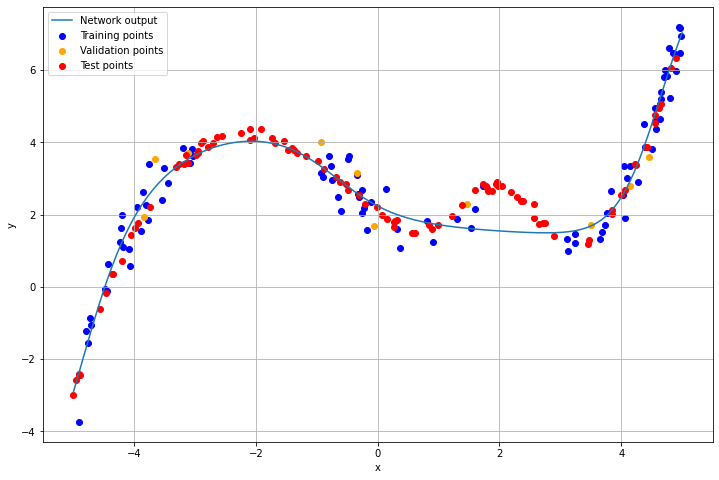

Average test loss: 0.2462676614522934


In [ ]:
net.plot(train_df,val_df,test_df)
test_loss = net.test(test_dataset)
print(f'Average test loss: {test_loss}')

# K fold 

In [10]:
class KFoldCrossValidator(object):
  '''
  Performs a k fold cross validation on a specific set of hyperparameters

  Args:
    k: int, number of folds
    n_runs: int or None: if n_runs < k, only the first n_runs will be performed.
            This is a quick workaround to speed up the hyperparameter optimization process
    shuffle: bool: if true data is shuffled before the splitting in k folds
    all_train_dataset: Dataset with train and validation data that will be split in folds

    net_type: user defined class
    net_params: dictionary or list of the arguments for net_type.__init__

    optimizer_type: e.g. optim.Adam
    optimizer_params: dictionary or list of the arguments of the optimizer (except net.parameters())

    loss_function
    train_batch_size: int, default 256

    trainer_type: e.g. Trainer or Trainer_es
    trainer_additional_params: dictionary with additional parameters for the trainer,
      e.g. if trainer_type = Trainer_es, the additional parameter 'patience' must be provided
  '''

  def __init__(self, k, n_runs=None, shuffle=False, all_train_dataset=None, net_type=None, net_params=None,
               optimizer_type=None, optimizer_params=None, loss_function=None,
               train_batch_size=256, trainer_type=None, trainer_additional_params={}):

    self.splitter = KFold(k,shuffle=shuffle)

    self.all_train_dataset = all_train_dataset

    self.net_type = net_type
    self.net_params = net_params
    self.optimizer_type = optimizer_type
    self.optimizer_params = optimizer_params

    self.train_batch_size = train_batch_size

    self.loss_function = loss_function

    self.trainer_type = trainer_type
    self.trainer_additional_params = trainer_additional_params

    self.trainers = []

    # set up the object with k (or n_runs) trainers
    i = 0
    for train_idx, val_idx in self.splitter.split(list(range(len(self.all_train_dataset)))):
      # datasets
      train_dataset = Subset(self.all_train_dataset, train_idx) # Sampler
      val_dataset = Subset(self.all_train_dataset, val_idx)

      # dataloaders
      train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
      val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

      # net
      if type(self.net_params) == dict:
        net = self.net_type(**self.net_params)
      else:
        net = self.net_type(*self.net_params)

      # optimizer
      if type(self.optimizer_params) == dict:
        optimizer = self.optimizer_type(net.parameters(),**self.optimizer_params) # keyword arguments 
      else:
        optimizer = self.optimizer_type(net.parameters(),*self.optimizer_params) # Tuple

      # trainer
      trainer = self.trainer_type(net=net,optimizer=optimizer,loss_function=loss_function,
                                  train_dataloader=train_dataloader,val_dataloader=val_dataloader, **self.trainer_additional_params)

      self.trainers.append(trainer)

      i += 1
      if n_runs is not None and i >= n_runs:
        break


  def run(self,num_epochs,loss_sample_size=10, prune_thr=None):
    '''
    Args:
      num_epochs: maximum number of epochs for each fold
      loss_sample_size: number of epochs for computing the average train and val losses, default 10
      prune_thr: folat or None: if one of the final validation losses is > prune thr, the run is interrupted raising a ValueError
    '''
    for k,trainer in enumerate(self.trainers):
      print(f'Fold  {k+1}')
      # move the net to the GPU
      trainer.net.to(device)
      trainer.train(num_epochs)
      # move the net back to free the GPU
      trainer.net.cpu()
      '''
      if prune_thr is not None and k < len(self.trainers)/2 and trainer.val_loss_log[-1] > prune_thr:
        print(f'Trial pruned: val loss was {trainer.val_loss_log[-1]}')
        raise ValueError
'''

      # print avg train and val loss
      print(f'###  train loss: {np.mean(trainer.train_loss_log[-loss_sample_size:])}')
      print(f'###  validation loss: {np.mean(trainer.val_loss_log[-loss_sample_size:])}')


    avg_train_loss = np.mean([np.mean(e.train_loss_log[-loss_sample_size:]) for e in self.trainers])
    avg_val_loss   = np.mean([np.mean(e.val_loss_log[-loss_sample_size:]) for e in self.trainers])
    print('\n\nResults')
    print(f'### Average train loss: {avg_train_loss}')
    print(f'### Average validation loss: {avg_val_loss}\n\n')
    return avg_train_loss, avg_val_loss
    



In [11]:
## TEST ##
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
activation_function = nn.Sigmoid()

net_type = Net
net_params = [Ni,Nh1,Nh2,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training
trainer_additional_params = {}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(100)

Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.378941297531128
###  validation loss: 2.948701858520508
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.446606159210205
###  validation loss: 3.035611152648926
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.8688855171203613
###  validation loss: 1.3552894592285156
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.377934217453003
###  validation loss: 3.1187806129455566
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.5178589820861816
###  validation loss: 2.5184788703918457


Results
### Average train loss: 2.518044948577881
### Average validation loss: 2.595372438430786




# Learing rate

In [ ]:
# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
activation_function = nn.Sigmoid()

net_type = Net
net_params = [Ni,Nh1,Nh2,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training
trainer_additional_params = {}

def objective(trial: optuna.trial.Trial) -> float:


    lr = trial.suggest_float("learning rate", 1e-5, 3)

    hyperparameters = dict(lr = lr)
    optimizer_params = {'lr': lr}
    # KFold

    kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                          optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                          train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

    train_loss, val_loss = kf.run(100)


    return val_loss
    



pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(direction="minimize", pruner=pruner, study_name = 'Learning rate ')
study.optimize(objective, n_trials=10, timeout=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))






[I 2022-02-03 06:59:34,702] A new study created in memory with name: Learning rate 


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.406583309173584
###  validation loss: 3.3031907081604004
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.194957733154297
###  validation loss: 3.583056688308716
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.605296611785889
###  validation loss: 2.1159706115722656
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.9151082038879395
###  validation loss: 5.9246721267700195
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 06:59:52,133] Trial 0 finished with value: 4.004768371582031 and parameters: {'learning rate': 2.6176487983269014}. Best is trial 0 with value: 4.004768371582031.


###  train loss: 4.009504318237305
###  validation loss: 5.096952438354492


Results
### Average train loss: 4.226290225982666
### Average validation loss: 4.004768371582031


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.778305768966675
###  validation loss: 5.176969051361084
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.69404935836792
###  validation loss: 2.972362995147705
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.111715316772461
###  validation loss: 5.2894673347473145
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.170433044433594
###  validation loss: 3.4488685131073
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:00:08,440] Trial 1 finished with value: 4.160601615905762 and parameters: {'learning rate': 0.28826944507911406}. Best is trial 0 with value: 4.004768371582031.


###  train loss: 4.687037944793701
###  validation loss: 3.9153404235839844


Results
### Average train loss: 4.288308143615723
### Average validation loss: 4.160601615905762


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.419210910797119
###  validation loss: 4.062485218048096
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.3402371406555176
###  validation loss: 6.839440822601318
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.5124311447143555
###  validation loss: 2.9841089248657227
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.2152228355407715
###  validation loss: 3.2694599628448486
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:00:24,813] Trial 2 finished with value: 3.988550901412964 and parameters: {'learning rate': 1.276163944340544}. Best is trial 2 with value: 3.988550901412964.


###  train loss: 4.303652763366699
###  validation loss: 2.787260055541992


Results
### Average train loss: 4.158151149749756
### Average validation loss: 3.988550901412964


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.013506889343262
###  validation loss: 5.155797481536865
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.4308295249938965
###  validation loss: 3.0778543949127197
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 5.603872776031494
###  validation loss: 5.696936130523682
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.435249328613281
###  validation loss: 3.0552096366882324
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:00:43,152] Trial 3 finished with value: 4.050232410430908 and parameters: {'learning rate': 1.2056476930503992}. Best is trial 2 with value: 3.988550901412964.


###  train loss: 4.246143817901611
###  validation loss: 3.2653632164001465


Results
### Average train loss: 4.545920372009277
### Average validation loss: 4.050232410430908


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.921893119812012
###  validation loss: 2.2709219455718994
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.323091983795166
###  validation loss: 4.188170909881592
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.280575752258301
###  validation loss: 3.515856981277466
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.5104522705078125
###  validation loss: 5.451321125030518
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:00:59,694] Trial 4 finished with value: 4.131556510925293 and parameters: {'learning rate': 2.0502784754453707}. Best is trial 2 with value: 3.988550901412964.


###  train loss: 3.6341450214385986
###  validation loss: 5.231513023376465


Results
### Average train loss: 4.134032249450684
### Average validation loss: 4.131556510925293


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.740902423858643
###  validation loss: 3.00056791305542
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.173789024353027
###  validation loss: 4.098857402801514
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.60708475112915
###  validation loss: 2.2099995613098145
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.7058894634246826
###  validation loss: 6.284605026245117
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:01:16,280] Trial 5 finished with value: 3.988969326019287 and parameters: {'learning rate': 2.2699764669774507}. Best is trial 2 with value: 3.988550901412964.


###  train loss: 4.081035614013672
###  validation loss: 4.350815773010254


Results
### Average train loss: 4.261740207672119
### Average validation loss: 3.988969326019287


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.606123924255371
###  validation loss: 2.8070390224456787
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.187626361846924
###  validation loss: 4.97830057144165
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.905111312866211
###  validation loss: 3.383958339691162
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.5588417053222656
###  validation loss: 5.215045928955078
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:01:32,846] Trial 6 finished with value: 4.164226531982422 and parameters: {'learning rate': 1.4282401448130995}. Best is trial 2 with value: 3.988550901412964.


###  train loss: 3.920581102371216
###  validation loss: 4.436788558959961


Results
### Average train loss: 4.235657215118408
### Average validation loss: 4.164226531982422


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.817328929901123
###  validation loss: 1.2703715562820435
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.255858421325684
###  validation loss: 3.52006196975708
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.8562495708465576
###  validation loss: 5.365777492523193
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.593120574951172
###  validation loss: 5.680881500244141
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:01:49,555] Trial 7 finished with value: 3.989534854888916 and parameters: {'learning rate': 0.9755246077841333}. Best is trial 2 with value: 3.988550901412964.


###  train loss: 4.390325546264648
###  validation loss: 4.110581874847412


Results
### Average train loss: 4.1825761795043945
### Average validation loss: 3.989534854888916


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.147609710693359
###  validation loss: 3.904101848602295
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.7686240673065186
###  validation loss: 4.743009567260742
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.7033393383026123
###  validation loss: 6.65811014175415
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.234139442443848
###  validation loss: 3.620314121246338
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:02:06,102] Trial 8 finished with value: 4.1246337890625 and parameters: {'learning rate': 2.440441694798444}. Best is trial 2 with value: 3.988550901412964.


###  train loss: 5.281599998474121
###  validation loss: 1.6976337432861328


Results
### Average train loss: 4.227062702178955
### Average validation loss: 4.1246337890625


Number of finished trials: 9
Best trial:
  Value: 3.988550901412964
  Params: 
    learning rate: 1.276163944340544


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

# Early stopping
Prevent overfitting and speed up the learing

In [12]:
class Training_es(Training):

  def __init__(self, patience, *args, **kwargs):
    '''
    Args:
      patience: int: if after patience epochs the validation loss does not decrease learning stops

      *args, **kwargs: arguments of the parent class
    '''
    super().__init__(*args, **kwargs)

    self.patience = patience
    self.counter = 0
    self.best_vl = 10


  def stop_learning(self,epoch_num):
    if epoch_num <= self.patience: # at least do 'patience' epochs
      return False

    if self.val_loss_log[-1] < self.best_vl:
      self.best_vl = self.val_loss_log[-1]
      self.counter =0

    else:
      self.counter += 1

    if self.counter >= self.patience:
      print('---> Early stopping')
      return True

In [13]:
# testing
k = 5

# net params
net_type = Net
net_params = {'Nh1': 128, 'Nh2': 128, 'activation_function': nn.ReLU()}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001, 'weight_decay': 0.001}

loss_function = nn.MSELoss()

train_batch_size = 20

trainer_type = Training_es
trainer_additional_params = {'patience': 5}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(100)


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.6118485331535339
###  validation loss: 0.5223154425621033
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.850827693939209
###  validation loss: 1.9331839084625244
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.2820045948028564
###  validation loss: 1.5305283069610596
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.7123293280601501
###  validation loss: 0.5262249708175659
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.7549340724945068
###  validation loss: 0.6995193362236023


Results
### Average train loss: 0.842388927936554
### Average validation loss: 1.0423543453216553




# Momentum

In [ ]:
## TEST ##
k = 5

net_type = Net
net_params = {'Nh1': 128, 'Nh2': 128, 'activation_function': nn.ReLU()}

# optimizer params
optimizer_type = optim.SGD
optimizer_params = {'lr': 0.001, 'momentum': 0.001}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training
trainer_additional_params = {}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(100)


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.9900319576263428
###  validation loss: 2.276470899581909
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.4575390815734863
###  validation loss: 1.4464213848114014
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.826443076133728
###  validation loss: 3.2409825325012207
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.1380908489227295
###  validation loss: 2.8145651817321777
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.0961482524871826
###  validation loss: 1.620661735534668


Results
### Average train loss: 2.1016507148742676
### Average validation loss: 2.279820442199707




In [ ]:
def objective(trial: optuna.trial.Trial) -> float:


    momentum = trial.suggest_float("momentum", 0.2, 0.8)

    hyperparameters = dict(momentum = momentum)
    optimizer_params = {'lr': 0.005159, 'momentum': momentum}
    # KFold

    kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                          optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                          train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

    train_loss, val_loss = kf.run(100)


    return val_loss
    



pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(direction="minimize", pruner=pruner, study_name = 'Momentum ')
study.optimize(objective, n_trials=10, timeout=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))




[I 2022-02-03 07:09:14,506] A new study created in memory with name: Momentum 


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.4812272787094116
###  validation loss: 1.0172393321990967
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.2549705505371094
###  validation loss: 2.136267900466919
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.3876729011535645
###  validation loss: 1.9656823873519897
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.3328863382339478
###  validation loss: 0.7885395288467407
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:09:29,672] Trial 0 finished with value: 1.5102109909057617 and parameters: {'momentum': 0.45487681361903065}. Best is trial 0 with value: 1.5102109909057617.


###  train loss: 1.2518903017044067
###  validation loss: 1.6433255672454834


Results
### Average train loss: 1.3417294025421143
### Average validation loss: 1.5102109909057617


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.492550253868103
###  validation loss: 1.1405949592590332
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.283421277999878
###  validation loss: 2.5167033672332764
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.6602121591567993
###  validation loss: 1.6451085805892944
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.3685873746871948
###  validation loss: 1.4107444286346436
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:09:44,965] Trial 1 finished with value: 1.5687614679336548 and parameters: {'momentum': 0.31035264991791833}. Best is trial 0 with value: 1.5102109909057617.


###  train loss: 1.431687593460083
###  validation loss: 1.1306560039520264


Results
### Average train loss: 1.4472917318344116
### Average validation loss: 1.5687614679336548


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.1322147846221924
###  validation loss: 1.1968069076538086
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.3354651927947998
###  validation loss: 1.3786664009094238
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.3273319005966187
###  validation loss: 1.2351057529449463
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.2995684146881104
###  validation loss: 2.747830629348755
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:10:00,045] Trial 2 finished with value: 1.5649864673614502 and parameters: {'momentum': 0.5525082218318689}. Best is trial 0 with value: 1.5102109909057617.


###  train loss: 1.500922679901123
###  validation loss: 1.2665224075317383


Results
### Average train loss: 1.3191006183624268
### Average validation loss: 1.5649864673614502


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.350722074508667
###  validation loss: 1.414275050163269
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.3729802370071411
###  validation loss: 1.407402753829956
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.3291493654251099
###  validation loss: 1.0779184103012085
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.9759379625320435
###  validation loss: 1.8756707906723022
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:10:15,251] Trial 3 finished with value: 1.4065622091293335 and parameters: {'momentum': 0.531516269822181}. Best is trial 3 with value: 1.4065622091293335.


###  train loss: 1.5348377227783203
###  validation loss: 1.2575442790985107


Results
### Average train loss: 1.3127254247665405
### Average validation loss: 1.4065622091293335


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.5809028148651123
###  validation loss: 1.223783016204834
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.518737554550171
###  validation loss: 1.2966431379318237
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.2604429721832275
###  validation loss: 2.211195945739746
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.3308844566345215
###  validation loss: 1.835101842880249
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:10:30,498] Trial 4 finished with value: 1.580794095993042 and parameters: {'momentum': 0.2933042527749844}. Best is trial 3 with value: 1.4065622091293335.


###  train loss: 1.5839053392410278
###  validation loss: 1.3372465372085571


Results
### Average train loss: 1.45497465133667
### Average validation loss: 1.580794095993042


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.3349196910858154
###  validation loss: 1.0413830280303955
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.1586635112762451
###  validation loss: 1.2558705806732178
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.426595687866211
###  validation loss: 1.7372125387191772
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.4004263877868652
###  validation loss: 1.2209337949752808
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:10:45,804] Trial 5 finished with value: 1.460720419883728 and parameters: {'momentum': 0.5223450649238209}. Best is trial 3 with value: 1.4065622091293335.


###  train loss: 1.150489091873169
###  validation loss: 2.0482022762298584


Results
### Average train loss: 1.2942187786102295
### Average validation loss: 1.460720419883728


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.8007664680480957
###  validation loss: 1.6780834197998047
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.1686689853668213
###  validation loss: 1.0344266891479492
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.9637981653213501
###  validation loss: 1.3899562358856201
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.2007052898406982
###  validation loss: 0.9889384508132935
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:11:00,882] Trial 6 finished with value: 1.2297741174697876 and parameters: {'momentum': 0.6640896077270415}. Best is trial 6 with value: 1.2297741174697876.


###  train loss: 1.4215803146362305
###  validation loss: 1.0574655532836914


Results
### Average train loss: 1.1111037731170654
### Average validation loss: 1.2297741174697876


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.3646748065948486
###  validation loss: 1.6371666193008423
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.4045279026031494
###  validation loss: 2.700465202331543
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.5148742198944092
###  validation loss: 0.9704626798629761
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.4732123613357544
###  validation loss: 0.7942070960998535
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:11:16,108] Trial 7 finished with value: 1.4984939098358154 and parameters: {'momentum': 0.426040764670347}. Best is trial 6 with value: 1.2297741174697876.


###  train loss: 1.1826016902923584
###  validation loss: 1.3901679515838623


Results
### Average train loss: 1.387978196144104
### Average validation loss: 1.4984939098358154


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0571569204330444
###  validation loss: 2.362840414047241
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.5140758752822876
###  validation loss: 1.4270039796829224
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.2589596509933472
###  validation loss: 1.3943710327148438
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.2175244092941284
###  validation loss: 1.003088116645813
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:11:31,351] Trial 8 finished with value: 1.4448391199111938 and parameters: {'momentum': 0.4441165753670213}. Best is trial 6 with value: 1.2297741174697876.


###  train loss: 1.3706847429275513
###  validation loss: 1.0368916988372803


Results
### Average train loss: 1.2836803197860718
### Average validation loss: 1.4448391199111938


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.8599656820297241
###  validation loss: 1.3238545656204224
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.7302839756011963
###  validation loss: 1.1457445621490479
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.1439217329025269
###  validation loss: 1.0774766206741333
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.8723527789115906
###  validation loss: 0.5832663774490356
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:11:46,583] Trial 9 finished with value: 1.0950206518173218 and parameters: {'momentum': 0.7204976735461941}. Best is trial 9 with value: 1.0950206518173218.


###  train loss: 0.8034445643424988
###  validation loss: 1.3447612524032593


Results
### Average train loss: 0.8819937705993652
### Average validation loss: 1.0950206518173218


Number of finished trials: 10
Best trial:
  Value: 1.0950206518173218
  Params: 
    momentum: 0.7204976735461941


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

# Momentum vs Learing rate

High value of momentum and learning rate lead to instability as show in the figure below

In [ ]:
## TEST ##
k = 5

net_type = Net
net_params = {'Nh1': 128, 'Nh2': 128, 'activation_function': nn.ReLU()}

# optimizer params
optimizer_type = optim.SGD
optimizer_params = {'lr': 0.09, 'momentum': 0.9}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training
trainer_additional_params = {}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(100)


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: nan
###  validation loss: nan
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: nan
###  validation loss: nan
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: nan
###  validation loss: nan
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: nan
###  validation loss: nan
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: nan
###  validation loss: nan


Results
### Average train loss: nan
### Average validation loss: nan




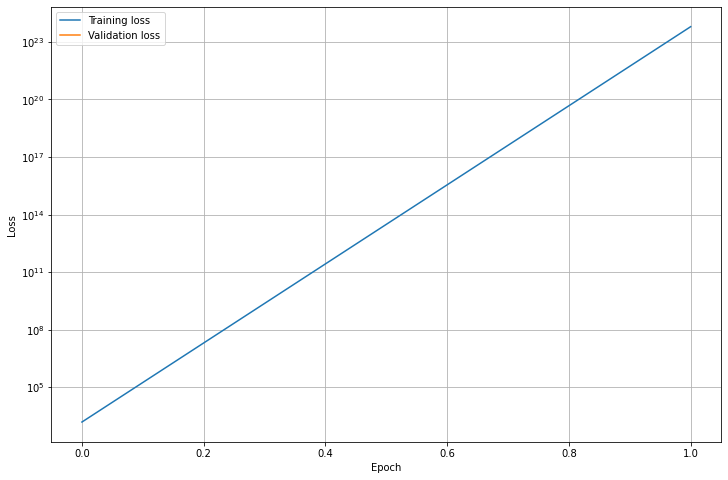

Average traininig  loss in the last 10 epochs: nan
Average validation loss in the last 10 epochs: nan


In [ ]:
kf.trainers[0].plot_losses()

While low value of such parameters lead to very poor results

In [ ]:
## TEST ##
k = 5

net_type = Net
net_params = {'Nh1': 128, 'Nh2': 128, 'activation_function': nn.ReLU()}

# optimizer params
optimizer_type = optim.SGD
optimizer_params = {'lr': 0.0001, 'momentum': 0.1}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training
trainer_additional_params = {}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(100)


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.956181049346924
###  validation loss: 4.993652820587158
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.0615391731262207
###  validation loss: 2.5890519618988037
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.192626476287842
###  validation loss: 3.1480534076690674
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.180774211883545
###  validation loss: 2.6807239055633545
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.962406635284424
###  validation loss: 2.7673349380493164


Results
### Average train loss: 3.0707054138183594
### Average validation loss: 3.2357635498046875




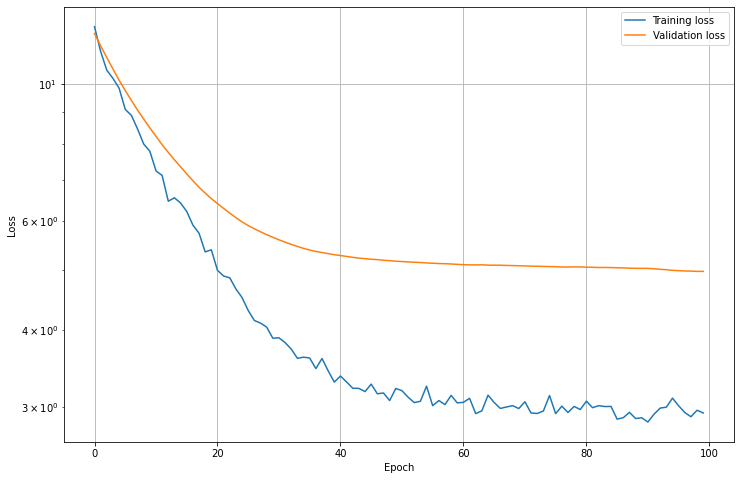

Average traininig  loss in the last 10 epochs: 2.9562
Average validation loss in the last 10 epochs: 4.9937


In [ ]:
kf.trainers[0].plot_losses()

In the following we are trying to get good value of them in order to get good results

In [ ]:
trainer_type = Training
trainer_additional_params = {}

def objective(trial: optuna.trial.Trial) -> float:

    momentum = trial.suggest_loguniform("momentum", 0.2, 0.8)
    lr = trial.suggest_float("learning rate", 1e-4, 1e-3)

    hyperparameters = dict(momentum = momentum, lr = lr)
    optimizer_params = {'lr': lr, 'momentum': momentum}
    # KFold

    kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                          optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                          train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

    train_loss, val_loss = kf.run(100)


    return val_loss
    



pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(direction="minimize", pruner=pruner, study_name = 'Momentum vs Learning rate')
study.optimize(objective, n_trials=10, timeout=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-03 07:38:44,363] A new study created in memory with name: Momentum vs Learning rate


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.0263023376464844
###  validation loss: 1.3066022396087646
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.107731580734253
###  validation loss: 2.2676687240600586
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.7650867700576782
###  validation loss: 3.192490339279175
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.0097806453704834
###  validation loss: 1.4525190591812134
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:39:02,144] Trial 0 finished with value: 2.2386913299560547 and parameters: {'momentum': 0.3581466784955795, 'learning rate': 0.0007578465527031745}. Best is trial 0 with value: 2.2386913299560547.


###  train loss: 2.0091984272003174
###  validation loss: 2.9741759300231934


Results
### Average train loss: 1.9836199283599854
### Average validation loss: 2.2386913299560547


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.1708922386169434
###  validation loss: 2.26080060005188
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.7485299110412598
###  validation loss: 4.1313018798828125
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.8184142112731934
###  validation loss: 2.847834348678589
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.6684226989746094
###  validation loss: 3.6649270057678223
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:39:17,738] Trial 1 finished with value: 3.0023598670959473 and parameters: {'momentum': 0.3333315800249039, 'learning rate': 0.00014367570632459488}. Best is trial 0 with value: 2.2386913299560547.


###  train loss: 3.0074591636657715
###  validation loss: 2.1069352626800537


Results
### Average train loss: 2.8827438354492188
### Average validation loss: 3.0023598670959473


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.141552448272705
###  validation loss: 2.1928248405456543
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.9327681064605713
###  validation loss: 3.5829989910125732
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.169677495956421
###  validation loss: 2.441925525665283
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.3919639587402344
###  validation loss: 1.5022025108337402
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:39:33,441] Trial 2 finished with value: 2.340273380279541 and parameters: {'momentum': 0.4162909961016006, 'learning rate': 0.00048051021496563646}. Best is trial 0 with value: 2.2386913299560547.


###  train loss: 2.460526466369629
###  validation loss: 1.98141610622406


Results
### Average train loss: 2.2192978858947754
### Average validation loss: 2.340273380279541


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.8762404918670654
###  validation loss: 4.759024620056152
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.5745325088500977
###  validation loss: 2.3215513229370117
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.559208393096924
###  validation loss: 1.7116791009902954
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.5245823860168457
###  validation loss: 1.8828102350234985
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:39:49,191] Trial 3 finished with value: 2.59946870803833 and parameters: {'momentum': 0.2864527098715219, 'learning rate': 0.0005581980625541203}. Best is trial 0 with value: 2.2386913299560547.


###  train loss: 2.37019681930542
###  validation loss: 2.3222765922546387


Results
### Average train loss: 2.3809521198272705
### Average validation loss: 2.59946870803833


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.9122867584228516
###  validation loss: 0.9378864169120789
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.8558976650238037
###  validation loss: 1.7945789098739624
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.592193365097046
###  validation loss: 2.085446834564209
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.8439983129501343
###  validation loss: 1.1847673654556274
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:40:05,030] Trial 4 finished with value: 1.8740389347076416 and parameters: {'momentum': 0.5732163792151616, 'learning rate': 0.0007935661613824477}. Best is trial 4 with value: 1.8740389347076416.


###  train loss: 1.49066162109375
###  validation loss: 3.3675148487091064


Results
### Average train loss: 1.739007592201233
### Average validation loss: 1.8740389347076416


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.1305320262908936
###  validation loss: 4.331240177154541
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.564103364944458
###  validation loss: 2.590319871902466
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.7402262687683105
###  validation loss: 2.262702226638794
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.457857608795166
###  validation loss: 2.727917194366455
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:40:20,917] Trial 5 finished with value: 2.807774305343628 and parameters: {'momentum': 0.3214785949179447, 'learning rate': 0.0002774018990040014}. Best is trial 4 with value: 1.8740389347076416.


###  train loss: 2.872844934463501
###  validation loss: 2.1266915798187256


Results
### Average train loss: 2.553112745285034
### Average validation loss: 2.807774305343628


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.9443628787994385
###  validation loss: 3.323768138885498
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.792335033416748
###  validation loss: 3.3077232837677
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.7641851902008057
###  validation loss: 3.9808952808380127
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.958601951599121
###  validation loss: 3.1550159454345703
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:40:36,984] Trial 6 finished with value: 3.1768758296966553 and parameters: {'momentum': 0.4631731423418436, 'learning rate': 0.00010341983681569017}. Best is trial 4 with value: 1.8740389347076416.


###  train loss: 3.1415457725524902
###  validation loss: 2.1169769763946533


Results
### Average train loss: 2.920206069946289
### Average validation loss: 3.1768758296966553


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.8011016845703125
###  validation loss: 2.0970120429992676
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.3323988914489746
###  validation loss: 3.5164973735809326
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.037224531173706
###  validation loss: 1.69802987575531
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.5558950901031494
###  validation loss: 3.5034842491149902
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:40:53,149] Trial 7 finished with value: 2.8388147354125977 and parameters: {'momentum': 0.28843682648677726, 'learning rate': 0.000244650226612186}. Best is trial 4 with value: 1.8740389347076416.


###  train loss: 2.602503538131714
###  validation loss: 3.3790500164031982


Results
### Average train loss: 2.6658246517181396
### Average validation loss: 2.8388147354125977


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.5422857999801636
###  validation loss: 2.220154285430908
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.6744482517242432
###  validation loss: 1.140704870223999
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.4864609241485596
###  validation loss: 1.8681535720825195
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.487358808517456
###  validation loss: 1.8899357318878174
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:41:09,140] Trial 8 finished with value: 1.6771520376205444 and parameters: {'momentum': 0.7982240428055682, 'learning rate': 0.000611267999429986}. Best is trial 8 with value: 1.6771520376205444.


###  train loss: 1.6123650074005127
###  validation loss: 1.2668119668960571


Results
### Average train loss: 1.5605837106704712
### Average validation loss: 1.6771520376205444


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.5373175144195557
###  validation loss: 2.2645821571350098
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.307018756866455
###  validation loss: 3.149893045425415
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.0678305625915527
###  validation loss: 3.4623241424560547
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.460928440093994
###  validation loss: 1.8789459466934204
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:41:25,215] Trial 9 finished with value: 2.539956569671631 and parameters: {'momentum': 0.6382344159260607, 'learning rate': 0.00025936646276881065}. Best is trial 8 with value: 1.6771520376205444.


###  train loss: 2.544661521911621
###  validation loss: 1.9440362453460693


Results
### Average train loss: 2.3835513591766357
### Average validation loss: 2.539956569671631


Number of finished trials: 10
Best trial:
  Value: 1.6771520376205444
  Params: 
    momentum: 0.7982240428055682
    learning rate: 0.000611267999429986


In [ ]:
fig = optuna.visualization.plot_contour(study, ['momentum', 'learning rate'])
fig.show()


# L2 regularization

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
activation_function = nn.ReLU()

net_type = Net
net_params = [Ni,Nh1,Nh2,No,activation_function]

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.005, 'weight_decay': 0.01}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training
trainer_additional_params = {}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(500)


Fold  1


  0%|          | 0/500 [00:00<?, ?it/s]

###  train loss: 0.27183064818382263
###  validation loss: 0.7458404302597046
Fold  2


  0%|          | 0/500 [00:00<?, ?it/s]

###  train loss: 0.3017319440841675
###  validation loss: 0.13203299045562744
Fold  3


  0%|          | 0/500 [00:00<?, ?it/s]

###  train loss: 0.30277425050735474
###  validation loss: 0.26556938886642456
Fold  4


  0%|          | 0/500 [00:00<?, ?it/s]

###  train loss: 0.34733450412750244
###  validation loss: 0.5122068524360657
Fold  5


  0%|          | 0/500 [00:00<?, ?it/s]

###  train loss: 0.26316407322883606
###  validation loss: 0.3457651138305664


Results
### Average train loss: 0.2973670959472656
### Average validation loss: 0.40028294920921326




In [ ]:
def objective(trial: optuna.trial.Trial) -> float:

    weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-2)

    hyperparameters = dict(weight_decay = weight_decay)
    optimizer_params = {'lr': 0.005, 'weight_decay': weight_decay}    # KFold

    kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                          optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                          train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

    train_loss, val_loss = kf.run(100)


    return val_loss
    



pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(direction="minimize", pruner=pruner, study_name = 'L2 regualrization')
study.optimize(objective, n_trials=10, timeout=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-03 07:49:13,889] A new study created in memory with name: L2 regualrization


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.3123777210712433
###  validation loss: 0.37562212347984314
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.27397996187210083
###  validation loss: 0.7159850597381592
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.3521135449409485
###  validation loss: 0.43037596344947815
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.3715933859348297
###  validation loss: 0.22881431877613068
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:49:32,577] Trial 0 finished with value: 0.4508679509162903 and parameters: {'weight_decay': 0.0016554476589796044}. Best is trial 0 with value: 0.4508679509162903.


###  train loss: 0.3511270582675934
###  validation loss: 0.5035423040390015


Results
### Average train loss: 0.3322383463382721
### Average validation loss: 0.4508679509162903


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.4382810592651367
###  validation loss: 0.2752264142036438
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.311095267534256
###  validation loss: 0.44629544019699097
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.273298978805542
###  validation loss: 0.6686696410179138
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.30409863591194153
###  validation loss: 0.36468127369880676
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:49:50,416] Trial 1 finished with value: 0.3778917193412781 and parameters: {'weight_decay': 0.0003742885538515116}. Best is trial 1 with value: 0.3778917193412781.


###  train loss: 0.33954739570617676
###  validation loss: 0.134585902094841


Results
### Average train loss: 0.3332642614841461
### Average validation loss: 0.3778917193412781


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.322406530380249
###  validation loss: 0.5507811307907104
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.3181022107601166
###  validation loss: 0.3515318036079407
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.37665513157844543
###  validation loss: 0.26744624972343445
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.3375152051448822
###  validation loss: 0.4635530412197113
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:50:08,196] Trial 2 finished with value: 0.4185605049133301 and parameters: {'weight_decay': 0.004679559015027874}. Best is trial 1 with value: 0.3778917193412781.


###  train loss: 0.42450135946273804
###  validation loss: 0.4594903588294983


Results
### Average train loss: 0.35583609342575073
### Average validation loss: 0.4185605049133301


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.39434558153152466
###  validation loss: 0.25383511185646057
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.40774470567703247
###  validation loss: 0.40464991331100464
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.5916412472724915
###  validation loss: 0.47443073987960815
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.31437164545059204
###  validation loss: 0.7034701108932495
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:50:26,166] Trial 3 finished with value: 0.5418092608451843 and parameters: {'weight_decay': 0.007548984575392576}. Best is trial 1 with value: 0.3778917193412781.


###  train loss: 0.3550296723842621
###  validation loss: 0.8726604580879211


Results
### Average train loss: 0.41262656450271606
### Average validation loss: 0.5418092608451843


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.31361979246139526
###  validation loss: 0.8575918078422546
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.3239034414291382
###  validation loss: 0.3435501158237457
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.38250255584716797
###  validation loss: 0.3847106993198395
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.41228756308555603
###  validation loss: 0.3528860807418823
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:50:44,872] Trial 4 finished with value: 0.4344797134399414 and parameters: {'weight_decay': 0.005643145713336082}. Best is trial 1 with value: 0.3778917193412781.


###  train loss: 0.47998523712158203
###  validation loss: 0.23365990817546844


Results
### Average train loss: 0.38245970010757446
### Average validation loss: 0.4344797134399414


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.43199053406715393
###  validation loss: 0.25458621978759766
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.3064253628253937
###  validation loss: 0.35126951336860657
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.3134419322013855
###  validation loss: 0.447756826877594
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.2290792465209961
###  validation loss: 0.6567578315734863
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:51:03,177] Trial 5 finished with value: 0.41284385323524475 and parameters: {'weight_decay': 0.0008292255653424089}. Best is trial 1 with value: 0.3778917193412781.


###  train loss: 0.3516819179058075
###  validation loss: 0.3538489043712616


Results
### Average train loss: 0.3265238106250763
### Average validation loss: 0.41284385323524475


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.36378490924835205
###  validation loss: 0.6453875303268433
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.32372960448265076
###  validation loss: 0.5056135058403015
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.43568143248558044
###  validation loss: 0.40385571122169495
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.4133313298225403
###  validation loss: 0.26031067967414856
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:51:21,254] Trial 6 finished with value: 0.43422120809555054 and parameters: {'weight_decay': 0.007108284823234931}. Best is trial 1 with value: 0.3778917193412781.


###  train loss: 0.353460431098938
###  validation loss: 0.3559388816356659


Results
### Average train loss: 0.37799757719039917
### Average validation loss: 0.43422120809555054


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.406050443649292
###  validation loss: 0.3045118451118469
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.37494799494743347
###  validation loss: 0.3795902132987976
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.25857070088386536
###  validation loss: 0.5110388994216919
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.5195740461349487
###  validation loss: 0.43209829926490784
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:51:39,538] Trial 7 finished with value: 0.41218334436416626 and parameters: {'weight_decay': 0.00310982136173976}. Best is trial 1 with value: 0.3778917193412781.


###  train loss: 0.3087955713272095
###  validation loss: 0.4336774945259094


Results
### Average train loss: 0.3735877573490143
### Average validation loss: 0.41218334436416626


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.34946608543395996
###  validation loss: 0.2364458292722702
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.32224252820014954
###  validation loss: 0.37374261021614075
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.3002430498600006
###  validation loss: 0.477871835231781
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.3534836173057556
###  validation loss: 0.2029532492160797
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:51:57,929] Trial 8 finished with value: 0.3676360249519348 and parameters: {'weight_decay': 0.00041580461013968013}. Best is trial 8 with value: 0.3676360249519348.


###  train loss: 0.32995331287384033
###  validation loss: 0.547166645526886


Results
### Average train loss: 0.3310776948928833
### Average validation loss: 0.3676360249519348


Number of finished trials: 9
Best trial:
  Value: 0.3676360249519348
  Params: 
    weight_decay: 0.00041580461013968013


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

# Dropout

In [14]:
class Net_d(Net):
  def __init__(self, dropout_prob_1=0, dropout_prob_2=0, **kwargs):
    '''
    Network with 2 hidden linear layers
    '''
    verbose = kwargs.get('verbose')
    kwargs['verbose'] = False
    super().__init__(**kwargs)
    self.d1 = nn.Dropout(dropout_prob_1)
    self.d2 = nn.Dropout(dropout_prob_2)

    if verbose:
      print('Network initialized')
    
  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.d1(x)
    x = self.act(self.fc2(x))
    x = self.d2(x)
    x = self.out(x)

    return x

In [15]:
# testing
k = 5

p = 0.3
net_type = Net_d
net_params = {'Nh1': 128, 'Nh2': 128, 'activation_function': nn.ReLU(),
              'dropout_prob_1': p, 'dropout_prob_2': p}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.005, 'weight_decay': 0.0013}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training_es
trainer_additional_params = {'patience': 100}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(500)


Fold  1


  0%|          | 0/500 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.6203639507293701
###  validation loss: 0.3683597445487976
Fold  2


  0%|          | 0/500 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.5145801305770874
###  validation loss: 0.3228191137313843
Fold  3


  0%|          | 0/500 [00:00<?, ?it/s]

###  train loss: 0.40340566635131836
###  validation loss: 0.7160447835922241
Fold  4


  0%|          | 0/500 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.5814179182052612
###  validation loss: 0.28436046838760376
Fold  5


  0%|          | 0/500 [00:00<?, ?it/s]

###  train loss: 0.4873930811882019
###  validation loss: 0.2851181626319885


Results
### Average train loss: 0.5214321613311768
### Average validation loss: 0.3953404426574707




In [ ]:
def objective(trial: optuna.trial.Trial) -> float:

    dropout = trial.suggest_float("dropout", 0.2, 0.8)

    hyperparameters = dict(dropout = dropout)
    net_params = {'Nh1': 128, 'Nh2': 128, 'activation_function': nn.ReLU(),
              'dropout_prob_1': dropout, 'dropout_prob_2': dropout}
    kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                          optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                          train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

    train_loss, val_loss = kf.run(100)


    return val_loss
    



pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(direction="minimize", pruner=pruner, study_name = 'Dropout')
study.optimize(objective, n_trials=10, timeout=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-03 07:53:09,647] A new study created in memory with name: Dropout


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0612072944641113
###  validation loss: 1.3671506643295288
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.1527612209320068
###  validation loss: 0.7226489782333374
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.2344751358032227
###  validation loss: 0.7963908910751343
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.2583072185516357
###  validation loss: 0.6690903902053833
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:53:27,787] Trial 0 finished with value: 0.783515989780426 and parameters: {'dropout': 0.3215579890271297}. Best is trial 0 with value: 0.783515989780426.


###  train loss: 1.3581690788269043
###  validation loss: 0.36229926347732544


Results
### Average train loss: 1.2129839658737183
### Average validation loss: 0.783515989780426


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.32524037361145
###  validation loss: 3.1517117023468018
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.36737060546875
###  validation loss: 1.724797248840332
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.1823136806488037
###  validation loss: 3.389859437942505
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.3640475273132324
###  validation loss: 1.8136504888534546
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:53:45,884] Trial 1 finished with value: 2.9041025638580322 and parameters: {'dropout': 0.7714369858856871}. Best is trial 0 with value: 0.783515989780426.


###  train loss: 2.7599947452545166
###  validation loss: 4.440494537353516


Results
### Average train loss: 3.1997933387756348
### Average validation loss: 2.9041025638580322


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.830568790435791
###  validation loss: 1.8111622333526611
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.311445951461792
###  validation loss: 2.522249698638916
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.7477617263793945
###  validation loss: 2.146960735321045
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.742945432662964
###  validation loss: 2.8927624225616455
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:54:04,010] Trial 2 finished with value: 2.333228349685669 and parameters: {'dropout': 0.6759450429969568}. Best is trial 0 with value: 0.783515989780426.


###  train loss: 2.537733316421509
###  validation loss: 2.2930057048797607


Results
### Average train loss: 2.6340909004211426
### Average validation loss: 2.333228349685669


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.5333733558654785
###  validation loss: 2.488723039627075
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.743006944656372
###  validation loss: 1.4925616979599
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.4605467319488525
###  validation loss: 3.190269947052002
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.896099090576172
###  validation loss: 1.7485692501068115
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:54:22,421] Trial 3 finished with value: 2.1252760887145996 and parameters: {'dropout': 0.6581204919721679}. Best is trial 0 with value: 0.783515989780426.


###  train loss: 2.923571825027466
###  validation loss: 1.7062568664550781


Results
### Average train loss: 2.7113194465637207
### Average validation loss: 2.1252760887145996


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.1520793437957764
###  validation loss: 1.5641748905181885
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.010840892791748
###  validation loss: 2.5501043796539307
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.5380260944366455
###  validation loss: 0.9998911023139954
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.0428175926208496
###  validation loss: 1.469094157218933
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:54:40,740] Trial 4 finished with value: 1.5654560327529907 and parameters: {'dropout': 0.5540743124584142}. Best is trial 0 with value: 0.783515989780426.


###  train loss: 1.9289216995239258
###  validation loss: 1.2440152168273926


Results
### Average train loss: 2.1345369815826416
### Average validation loss: 1.5654560327529907


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0057803392410278
###  validation loss: 0.5501937866210938
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.075687050819397
###  validation loss: 0.7808530330657959
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0590369701385498
###  validation loss: 1.5307226181030273
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0245542526245117
###  validation loss: 0.43888092041015625
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:54:59,074] Trial 5 finished with value: 0.7714592814445496 and parameters: {'dropout': 0.2908874560082929}. Best is trial 5 with value: 0.7714592814445496.


###  train loss: 0.9870513677597046
###  validation loss: 0.5566461086273193


Results
### Average train loss: 1.0304219722747803
### Average validation loss: 0.7714592814445496


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0396039485931396
###  validation loss: 0.7795333862304688
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.196630835533142
###  validation loss: 0.5319103598594666
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.9965013265609741
###  validation loss: 0.40783968567848206
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0890828371047974
###  validation loss: 1.515774130821228
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:55:17,550] Trial 6 finished with value: 0.7907016277313232 and parameters: {'dropout': 0.274519716691}. Best is trial 5 with value: 0.7714592814445496.


###  train loss: 1.1354238986968994
###  validation loss: 0.7184504866600037


Results
### Average train loss: 1.0914485454559326
### Average validation loss: 0.7907016277313232


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.7965965270996094
###  validation loss: 2.3497018814086914
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.54353666305542
###  validation loss: 2.709699869155884
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.268484592437744
###  validation loss: 2.784445285797119
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.8165109157562256
###  validation loss: 1.2472999095916748
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:55:36,063] Trial 7 finished with value: 2.0313820838928223 and parameters: {'dropout': 0.6342709023157662}. Best is trial 5 with value: 0.7714592814445496.


###  train loss: 2.488463878631592
###  validation loss: 1.0657644271850586


Results
### Average train loss: 2.58271861076355
### Average validation loss: 2.0313820838928223


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.9112041592597961
###  validation loss: 0.5888451933860779
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0017569065093994
###  validation loss: 0.6165308356285095
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.9822192192077637
###  validation loss: 0.52671879529953
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.307037115097046
###  validation loss: 1.4322364330291748
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 07:55:54,476] Trial 8 finished with value: 0.7573875188827515 and parameters: {'dropout': 0.2541557193848787}. Best is trial 8 with value: 0.7573875188827515.


###  train loss: 1.1417510509490967
###  validation loss: 0.622606635093689


Results
### Average train loss: 1.0687936544418335
### Average validation loss: 0.7573875188827515


Number of finished trials: 9
Best trial:
  Value: 0.7573875188827515
  Params: 
    dropout: 0.2541557193848787


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

# Optimizers

In [ ]:
def configure_optimizers(opt , momentum, weight_decay = 0 ,  lr = 0.01):
        if opt == 'Adam':
          optimizer = optim.Adam
          optimizer_params = {'lr':lr, 'weight_decay':weight_decay}
        elif opt == 'SGD':
          optimizer = optim.SGD
          optimizer_params = {'lr':lr, 'weight_decay':weight_decay}
        elif opt == 'momentumSGD':
          optimizer = optim.SGD
          optimizer_params = {'lr':lr, 'weight_decay':weight_decay, 'momentum': momentum}
        elif opt == 'RMSprop':
          optimizer = optim.RMSprop
          optimizer_params = {'lr':lr, 'weight_decay':weight_decay, 'momentum': momentum}
        else: 
          print("Default optimizer : Adam")
          optimizer = optim.Adam
          optimizer_params = {'lr':lr, 'weight_decay':weight_decay}
        return optimizer, optimizer_params

In [ ]:
# testing
k = 5

# net params
Ni = No = 1
Nh1 = 128
Nh2 = 128
activation_function = nn.ReLU()
trainer_type = Training
trainer_additional_params = {}

net_type = Net
net_params = [Ni,Nh1,Nh2,No,activation_function]
train_batch_size = 30



loss_function = nn.MSELoss()






def objective(trial: optuna.trial.Trial) -> float:

    # optimizer params
    optimizer = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'momentumSGD', 'RMSprop'])
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-1)
    momentum = trial.suggest_float("momentum", 0.2, 0.8)
    lr = trial.suggest_loguniform("learning rate", 1e-5, 1e-2)

    optimizer_type, optimizer_params = configure_optimizers(optimizer, weight_decay, momentum, lr)
    

    hyperparameters = dict(weight_decay = weight_decay)

    kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                          optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                          train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

    train_loss, val_loss = kf.run(100)


    return val_loss
    



pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(direction="minimize", pruner=pruner, study_name = 'Optimizers')
study.optimize(objective, n_trials=20, timeout=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-03 08:37:47,688] A new study created in memory with name: Optimizers


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.0818352699279785
###  validation loss: 2.708040714263916
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.465221405029297
###  validation loss: 4.876175403594971
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.382103443145752
###  validation loss: 4.8128838539123535
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.314564228057861
###  validation loss: 3.5477614402770996
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 08:38:03,228] Trial 0 finished with value: 3.8406119346618652 and parameters: {'optimizer': 'SGD', 'weight_decay': 0.007203677410454589, 'momentum': 0.3381898574925708, 'learning rate': 3.457815554774902e-05}. Best is trial 0 with value: 3.8406119346618652.


###  train loss: 3.9228832721710205
###  validation loss: 3.258197784423828


Results
### Average train loss: 3.8333218097686768
### Average validation loss: 3.8406119346618652


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.8250125646591187
###  validation loss: 2.054287910461426
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.1654627323150635
###  validation loss: 1.161575436592102
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.1650888919830322
###  validation loss: 1.1724531650543213
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.1375789642333984
###  validation loss: 2.2815518379211426
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 08:38:19,281] Trial 1 finished with value: 2.0484418869018555 and parameters: {'optimizer': 'momentumSGD', 'weight_decay': 0.04553467086537269, 'momentum': 0.4168637713363066, 'learning rate': 0.0023632675445865742}. Best is trial 1 with value: 2.0484418869018555.


###  train loss: 1.6778860092163086
###  validation loss: 3.5723414421081543


Results
### Average train loss: 1.9942058324813843
### Average validation loss: 2.0484418869018555


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.813415765762329
###  validation loss: 2.9705824851989746
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.237389326095581
###  validation loss: 1.844731092453003
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.105698823928833
###  validation loss: 1.9783588647842407
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.132279872894287
###  validation loss: 1.7559826374053955
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 08:38:37,334] Trial 2 finished with value: 2.1190528869628906 and parameters: {'optimizer': 'Adam', 'weight_decay': 0.0002967977595543598, 'momentum': 0.42841735196233266, 'learning rate': 0.0040006402010502725}. Best is trial 1 with value: 2.0484418869018555.


###  train loss: 2.049445390701294
###  validation loss: 2.045609951019287


Results
### Average train loss: 2.067645788192749
### Average validation loss: 2.1190528869628906


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.55845308303833
###  validation loss: 2.296905755996704
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.4541194438934326
###  validation loss: 2.827146530151367
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.1329357624053955
###  validation loss: 4.1550068855285645
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.7319416999816895
###  validation loss: 2.0534749031066895
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 08:38:55,449] Trial 3 finished with value: 2.671769857406616 and parameters: {'optimizer': 'Adam', 'weight_decay': 0.0054717680788896215, 'momentum': 0.7765301789874717, 'learning rate': 0.004886389379637952}. Best is trial 1 with value: 2.0484418869018555.


###  train loss: 2.5075435638427734
###  validation loss: 2.0263166427612305


Results
### Average train loss: 2.4769985675811768
### Average validation loss: 2.671769857406616


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 5.488339424133301
###  validation loss: 5.2422661781311035
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.7511491775512695
###  validation loss: 4.121555328369141
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 5.733587265014648
###  validation loss: 5.835463523864746
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 5.893301963806152
###  validation loss: 6.924166679382324
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 08:39:13,694] Trial 4 finished with value: 5.797229290008545 and parameters: {'optimizer': 'Adam', 'weight_decay': 0.09160067041109082, 'momentum': 0.7631698723806091, 'learning rate': 1.71328640204602e-05}. Best is trial 1 with value: 2.0484418869018555.


###  train loss: 5.517622947692871
###  validation loss: 6.862696170806885


Results
### Average train loss: 5.476800441741943
### Average validation loss: 5.797229290008545


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 7.846792697906494
###  validation loss: 7.122474670410156
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 5.558979034423828
###  validation loss: 4.483767509460449
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 6.064670562744141
###  validation loss: 8.305667877197266
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 5.342835426330566
###  validation loss: 6.617029666900635
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 08:39:30,932] Trial 5 finished with value: 6.467292785644531 and parameters: {'optimizer': 'momentumSGD', 'weight_decay': 0.012795638089185461, 'momentum': 0.6640321851396294, 'learning rate': 1.5786980459773694e-05}. Best is trial 1 with value: 2.0484418869018555.


###  train loss: 7.692451477050781
###  validation loss: 5.807522296905518


Results
### Average train loss: 6.501145839691162
### Average validation loss: 6.467292785644531


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.931825637817383
###  validation loss: 3.4923834800720215
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.670010566711426
###  validation loss: 4.25496768951416
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.5273795127868652
###  validation loss: 7.4869537353515625
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 4.922564506530762
###  validation loss: 4.385035514831543
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 08:39:48,997] Trial 6 finished with value: 4.580089092254639 and parameters: {'optimizer': 'RMSprop', 'weight_decay': 0.00023015727280506222, 'momentum': 0.22128930888978654, 'learning rate': 1.4150365778360292e-05}. Best is trial 1 with value: 2.0484418869018555.


###  train loss: 4.262315273284912
###  validation loss: 3.281106948852539


Results
### Average train loss: 4.4628190994262695
### Average validation loss: 4.580089092254639


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.259059190750122
###  validation loss: 2.422234058380127
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.199951648712158
###  validation loss: 1.6486835479736328
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.904727578163147
###  validation loss: 3.5939712524414062
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.342381000518799
###  validation loss: 1.981797456741333
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 08:40:07,397] Trial 7 finished with value: 2.3848183155059814 and parameters: {'optimizer': 'Adam', 'weight_decay': 0.005771643843298311, 'momentum': 0.7338923852272443, 'learning rate': 0.0023631728767191432}. Best is trial 1 with value: 2.0484418869018555.


###  train loss: 2.303757667541504
###  validation loss: 2.277404308319092


Results
### Average train loss: 2.2019753456115723
### Average validation loss: 2.3848183155059814


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.1237494945526123
###  validation loss: 1.687585473060608
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.6897649765014648
###  validation loss: 4.367289066314697
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.0669138431549072
###  validation loss: 2.046891689300537
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.006748676300049
###  validation loss: 1.8258581161499023
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 08:40:25,686] Trial 8 finished with value: 2.2776856422424316 and parameters: {'optimizer': 'RMSprop', 'weight_decay': 0.00011873159887179902, 'momentum': 0.5398410071442897, 'learning rate': 0.0007354500236725467}. Best is trial 1 with value: 2.0484418869018555.


###  train loss: 2.2193832397460938
###  validation loss: 1.460803508758545


Results
### Average train loss: 2.0213119983673096
### Average validation loss: 2.2776856422424316


Number of finished trials: 9
Best trial:
  Value: 2.0484418869018555
  Params: 
    optimizer: momentumSGD
    weight_decay: 0.04553467086537269
    momentum: 0.4168637713363066
    learning rate: 0.0023632675445865742


# Different net structure

## Solution 2

In [17]:
class Net3(Net):
  def __init__(self, Nh3, **kwargs):
    '''
    Network with 3 hidden linear layers
    '''
    Nh2 = kwargs.get('Nh2')
    verbose = kwargs.get('verbose')
    kwargs['verbose'] = False
    super().__init__(**kwargs)

    self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
    self.out = nn.Linear(in_features=Nh3,out_features=self.No)

    if verbose:
      print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.act(self.fc3(x))
    x = self.out(x)

    return x

In [ ]:
# testing
k = 5

net_type = Net3
net_params = {'Nh1': 128, 'Nh2': 20, 'Nh3': 128, 'activation_function': nn.ReLU()}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.005, 'weight_decay': 0.0013}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training_es
trainer_additional_params = {'patience': 100}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(1000)

Fold  1


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.22968916594982147
###  validation loss: 0.2238880693912506
Fold  2


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.2783797085285187
###  validation loss: 0.4122774600982666
Fold  3


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.31458085775375366
###  validation loss: 0.41118860244750977
Fold  4


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.2136848419904709
###  validation loss: 0.6146755814552307
Fold  5


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.2681945860385895
###  validation loss: 0.2687137722969055


Results
### Average train loss: 0.26090580224990845
### Average validation loss: 0.38614869117736816




In [ ]:
class Net3_d(Net3):
  def __init__(self, dropout_prob_1=0, dropout_prob_2=0, dropout_prob_3=0, **kwargs):
    '''
    Network with 3 hidden linear layers
    '''
    verbose = kwargs.get('verbose')
    kwargs['verbose'] = False
    super().__init__(**kwargs)

    self.d1 = nn.Dropout(dropout_prob_1)
    self.d2 = nn.Dropout(dropout_prob_2)
    self.d3 = nn.Dropout(dropout_prob_3)

    if verbose:
      print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.d1(x)
    x = self.act(self.fc2(x))
    x = self.d2(x)
    x = self.act(self.fc3(x))
    x = self.d3(x)
    x = self.out(x)

    return x

In [ ]:
# testing
k = 5

net_type = Net3_d
net_params = {'Nh1': 128, 'Nh2': 128, 'Nh3': 64, 'activation_function': nn.ReLU(),
              'dropout_prob_1': 0.3, 'dropout_prob_2': 0.4, 'dropout_prob_3': 0}


# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.005, 'weight_decay': 0.0013}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training_es
trainer_additional_params = {'patience': 100}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(1000)

Fold  1


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.5290798544883728
###  validation loss: 0.46524137258529663
Fold  2


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.5475769639015198
###  validation loss: 0.26471078395843506
Fold  3


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.5536205172538757
###  validation loss: 0.9442451596260071
Fold  4


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.5640184283256531
###  validation loss: 0.6152266263961792
Fold  5


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.43175554275512695
###  validation loss: 0.2859756052494049


Results
### Average train loss: 0.5252102613449097
### Average validation loss: 0.515079915523529




## Solution 3

In [ ]:
class Net4(Net3):
  def __init__(self, Nh4, **kwargs):
    '''
    Network with 3 hidden linear layers
    '''
    Nh3 = kwargs.get('Nh3')
    verbose = kwargs.get('verbose')
    kwargs['verbose'] = False
    super().__init__(**kwargs)

    self.fc4 = nn.Linear(in_features=Nh3, out_features=Nh4)
    self.out = nn.Linear(in_features=Nh4,out_features=self.No)

    if verbose:
      print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.act(self.fc3(x))
    x = self.act(self.fc4(x))
    x = self.out(x)

    return x

In [ ]:
# testing
k = 5

net_type = Net4
net_params = {'Nh1': 8, 'Nh2': 64, 'Nh3': 128, 'Nh4': 16, 'activation_function': nn.Tanh()}


# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.005, 'weight_decay': 0.0013}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training_es
trainer_additional_params = {'patience': 100}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(1000)

Fold  1


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.1877617835998535
###  validation loss: 2.18508243560791
Fold  2


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.5947562456130981
###  validation loss: 0.5370872616767883
Fold  3


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.5206772089004517
###  validation loss: 0.5079289078712463
Fold  4


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.49863162636756897
###  validation loss: 0.7801557779312134
Fold  5


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.0979251861572266
###  validation loss: 2.5468461513519287


Results
### Average train loss: 1.1799503564834595
### Average validation loss: 1.3114200830459595




In [ ]:
class Net4_d(Net4):
  def __init__(self, dropout_prob_1=0, dropout_prob_2=0, dropout_prob_3=0, dropout_prob_4=0, **kwargs):
    '''
    Network with 3 hidden linear layers
    '''
    verbose = kwargs.get('verbose')
    kwargs['verbose'] = False
    super().__init__(**kwargs)

    self.d1 = nn.Dropout(dropout_prob_1)
    self.d2 = nn.Dropout(dropout_prob_2)
    self.d3 = nn.Dropout(dropout_prob_3)
    self.d4 = nn.Dropout(dropout_prob_4)

    if verbose:
      print('Network initialized')

  def forward(self, x):

    x = self.act(self.fc1(x))
    x = self.d1(x)
    x = self.act(self.fc2(x))
    x = self.d2(x)
    x = self.act(self.fc3(x))
    x = self.d3(x)
    x = self.act(self.fc4(x))
    x = self.d4(x)
    x = self.out(x)

    return x

In [ ]:
k = 5

# net params
net_type = Net4_d
net_params = {'Nh1': 32, 'Nh2': 128, 'Nh3': 64, 'Nh4': 256, 'activation_function': nn.Tanh(),
                'dropout_prob_1': 0, 'dropout_prob_2': 0.5, 'dropout_prob_3': 0, 'dropout_prob_4': 0}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.005, 'weight_decay': 0.0013}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training_es
trainer_additional_params = {'patience': 100}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ = kf.run(1000)

Fold  1


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.3641006052494049
###  validation loss: 0.23671400547027588
Fold  2


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.32383307814598083
###  validation loss: 0.5904557704925537
Fold  3


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.5028959512710571
###  validation loss: 0.3138512969017029
Fold  4


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.4497928023338318
###  validation loss: 0.48814287781715393
Fold  5


  0%|          | 0/1000 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.36692699790000916
###  validation loss: 0.4190593361854553


Results
### Average train loss: 0.4015098512172699
### Average validation loss: 0.4096446633338928




# Final test

## Training

In [27]:
net_params = {'Nh1': 128, 'Nh2': 20, 'Nh3': 128, 'activation_function': nn.ReLU()}
net = Net3(**net_params).to(device)

optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=0.1)

loss_function = nn.MSELoss()

train_dataloader = DataLoader(CsvDataset(all_train_df,transform=composed_transform), batch_size=train_batch_size, shuffle=True, num_workers=0)


trainer = Training(net=net,optimizer=optimizer,loss_function=loss_function,train_dataloader=train_dataloader,val_dataloader=None)

In [28]:
trainer.train(1000, verbose = False)

  0%|          | 0/1000 [00:00<?, ?it/s]

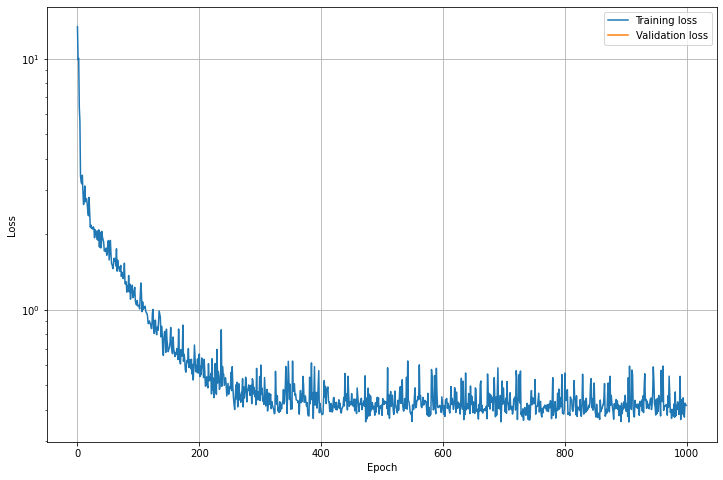

Average traininig  loss in the last 10 epochs: 0.4061
Average validation loss in the last 10 epochs: nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
trainer.plot_losses()

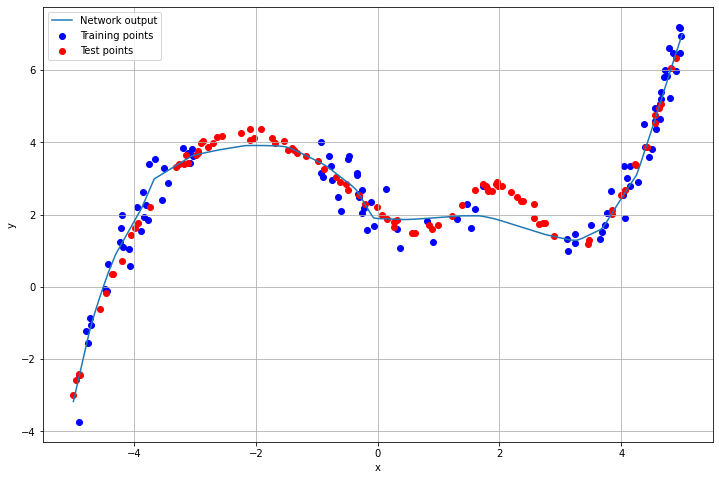

Test loss = 0.15872249007225037


In [21]:
trainer.plot(train_df=all_train_df,test_df=test_df)
test_loss = trainer.test(test_dataset)
print(f'Test loss = {test_loss}')

# Visualization 


## Weights

In [30]:
net_params = {'Nh1': 128, 'Nh2': 20, 'Nh3': 128, 'activation_function': nn.ReLU()}
net = Net3(**net_params)
net = trainer.net
print(net)

Net3(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (act): ReLU()
  (fc3): Linear(in_features=20, out_features=128, bias=True)
)


In [31]:
h1_w = net.fc1.weight.data.cpu().numpy()
h2_w = net.fc2.weight.data.cpu().numpy()
h3_w = net.fc3.weight.data.cpu().numpy()
out_w = net.out.weight.data.cpu().numpy()


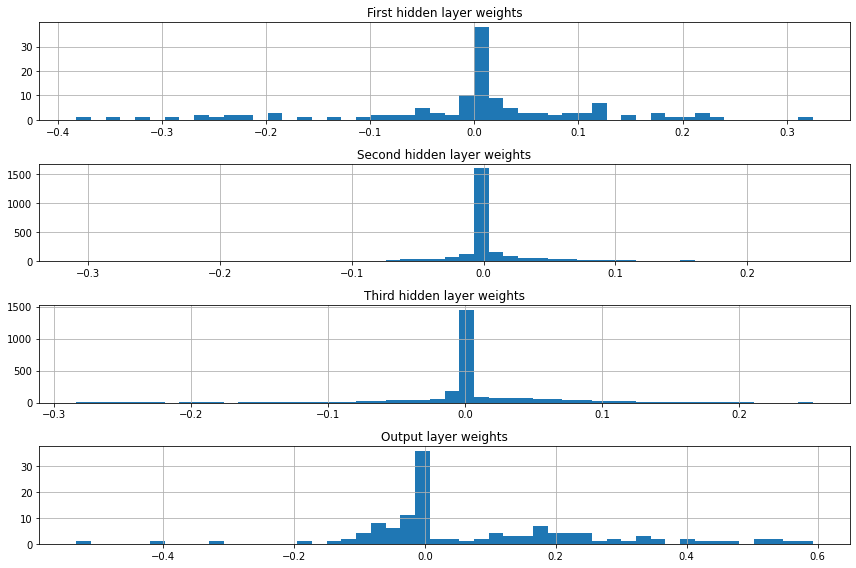

In [32]:
# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Third hidden layer weights')
axs[3].hist(out_w.flatten(), 50)
axs[3].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

## Activation profile

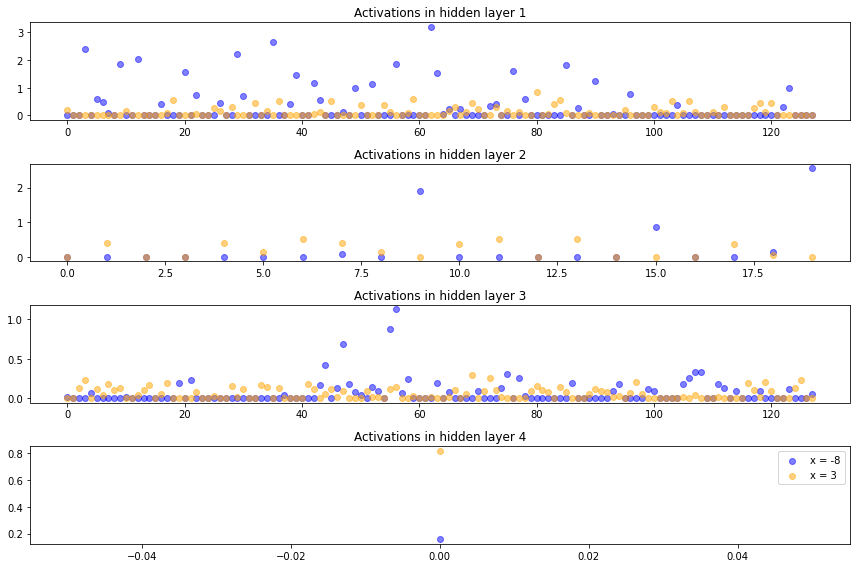

In [33]:
# Test datapoints 
x1 = -8
x2 = 3


#define a hook for each layer

def get_activation1(layer, input, output):
    global activation1 # define global variable in which to store the activations.
    activation1 = torch.relu(output)

hook_handle1 = net.fc1.register_forward_hook(get_activation1)

def get_activation2(layer, input, output):
    global activation2 # define global variable in which to store the activations.
    activation2 = torch.relu(output)

hook_handle2 = net.fc2.register_forward_hook(get_activation2)

def get_activation3(layer, input, output):
    global activation3 # define global variable in which to store the activations.
    activation3 = torch.relu(output)

hook_handle3 = net.fc3.register_forward_hook(get_activation3)

def get_activation4(layer, input, output):
    global activation4 # define global variable in which to store the activations.
    activation4 = torch.sigmoid(output)

hook_handle4 = net.out.register_forward_hook(get_activation4)

# evaluate the net
net = net.to(device)
net.eval()
with torch.no_grad():
    x = torch.tensor([x1]).float().to(device)
    y = net(x)
    a1 = activation1.cpu().numpy()
    a2 = activation2.cpu().numpy()
    a3 = activation3.cpu().numpy()
    a4 = activation4.cpu().numpy()

    x = torch.tensor([x2]).float().to(device)
    y = net(x)
    a1b = activation1.cpu().numpy()
    a2b = activation2.cpu().numpy()
    a3b = activation3.cpu().numpy()
    a4b = activation4.cpu().numpy()

a_s = [a1,a2,a3,a4]
ab_s = [a1b,a2b,a3b,a4b]

# remove hooks
hook_handle1.remove()
hook_handle2.remove()
hook_handle3.remove()
hook_handle4.remove()

#plot activations
fig, axs = plt.subplots(4,1, figsize=(12,8))
for i,a in enumerate(a_s):
  axs[i].scatter(np.arange(len(a)), a,label=f'x = {x1}',color='blue', alpha=0.5)
  axs[i].set_title(f'Activations in hidden layer {i + 1}')

for i,a in enumerate(ab_s):
  axs[i].scatter(np.arange(len(a)), a,label=f'x = {x2}',color='orange', alpha=0.5)
  axs[i].set_title(f'Activations in hidden layer {i + 1}')

plt.legend()

fig.tight_layout()

# Optuna optimization

In [ ]:


k = 5
runs = 2

net_type = Net_d
optimizer_type = optim.Adam

name = 'Regression - best net'
loss_function = nn.MSELoss()

train_batch_size = 256

trainer_type = Training_es
trainer_additional_params = {'patience': 10} # no checkpoint to speed up the training

def objective(trial):


  # sample hypermarameters
  

  # linear layers part
  p1 = trial.suggest_float('p1', 0, 0.7)
  p2 = trial.suggest_float('p2', 0, 0.7)
  Nh1 = trial.suggest_int('Nh1', 16, 256)
  Nh2 = trial.suggest_int('Nh2', 4, 128)

  # optimizer part
  lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
  weight_decay = trial.suggest_float('weight_decay', 1e-7,1e-1, log=True)

  params ={'Nh1': 128, 'Nh2': 128, 'activation_function': nn.ReLU(),
              'dropout_prob_1': p1, 'dropout_prob_2': p2}

  
  optimizer_params = {'lr': lr, 'weight_decay': weight_decay}


  kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

  avg_tr_loss, avg_val_loss = kf.run(100)
  

  # dictionary with all the hyperparameters and performance of the net
  hyper_dict = dict(**net_params, **optimizer_params, **{'avg_tr_loss': avg_tr_loss, 'avg_val_loss': avg_val_loss})



  return np.mean([e.best_vl for e in kf.trainers]) 


study = optuna.create_study(study_name=name, direction="minimize")

[I 2022-02-03 09:16:53,386] A new study created in memory with name: Regression - best net


In [ ]:
study.optimize(objective, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.6058101654052734
###  validation loss: 2.702845811843872
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.233642578125
###  validation loss: 2.705683469772339
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.3552792072296143
###  validation loss: 3.703089952468872
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.9635515213012695
###  validation loss: 2.7805724143981934
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:17:00,200] Trial 0 finished with value: 3.023083209991455 and parameters: {'p1': 0.40907971496371537, 'p2': 0.13038889527506894, 'Nh1': 40, 'Nh2': 105, 'lr': 0.0005687124735572558, 'weight_decay': 0.00019770464216276853}. Best is trial 0 with value: 3.023083209991455.


---> Early stopping
###  train loss: 3.498378276824951
###  validation loss: 4.166818618774414


Results
### Average train loss: 3.3313324451446533
### Average validation loss: 3.2118020057678223


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 7.107008457183838
###  validation loss: 6.062243461608887
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 6.275447845458984
###  validation loss: 8.533342361450195
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 4.979763984680176
###  validation loss: 3.2418861389160156
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 6.161348819732666
###  validation loss: 4.427160739898682
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:17:05,574] Trial 1 finished with value: 2.98016095161438 and parameters: {'p1': 0.3772093017746512, 'p2': 0.40236925314900773, 'Nh1': 117, 'Nh2': 121, 'lr': 0.03687004873670173, 'weight_decay': 0.0019375385875957621}. Best is trial 1 with value: 2.98016095161438.


---> Early stopping
###  train loss: 3.361818790435791
###  validation loss: 1.4777443408966064


Results
### Average train loss: 5.577077388763428
### Average validation loss: 4.748475074768066


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 4.369711875915527
###  validation loss: 2.903407096862793
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 13.260159492492676
###  validation loss: 10.455846786499023
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 6.749603271484375
###  validation loss: 8.914996147155762
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 12.910421371459961
###  validation loss: 11.049428939819336
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:17:09,902] Trial 2 finished with value: 5.634612226486206 and parameters: {'p1': 0.4985346183210518, 'p2': 0.3447527731366861, 'Nh1': 76, 'Nh2': 127, 'lr': 0.09192512693248424, 'weight_decay': 0.0010522830440282752}. Best is trial 1 with value: 2.98016095161438.


---> Early stopping
###  train loss: 7.729691982269287
###  validation loss: 5.565592288970947


Results
### Average train loss: 9.00391674041748
### Average validation loss: 7.777853965759277


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 12.857839584350586
###  validation loss: 15.090682983398438
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 7.097891330718994
###  validation loss: 5.826380729675293
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 8.659910202026367
###  validation loss: 11.515332221984863
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 9.215723037719727
###  validation loss: 5.053060531616211
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:17:17,238] Trial 3 finished with value: 8.136247730255127 and parameters: {'p1': 0.1882314977327604, 'p2': 0.20813472107219624, 'Nh1': 237, 'Nh2': 25, 'lr': 2.5685838223983177e-05, 'weight_decay': 3.088845820985362e-07}. Best is trial 1 with value: 2.98016095161438.


---> Early stopping
###  train loss: 12.394218444824219
###  validation loss: 13.613685607910156


Results
### Average train loss: 10.045116424560547
### Average validation loss: 10.219828605651855


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.6250252723693848
###  validation loss: 1.7134723663330078
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.1928093433380127
###  validation loss: 1.827419638633728
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.575669765472412
###  validation loss: 2.0901942253112793
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.167337417602539
###  validation loss: 2.804455041885376
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:17:22,252] Trial 4 finished with value: 1.8659303188323975 and parameters: {'p1': 0.5245752991284344, 'p2': 0.0985455743816808, 'Nh1': 224, 'Nh2': 106, 'lr': 0.006241599656716549, 'weight_decay': 2.01203100328083e-06}. Best is trial 4 with value: 1.8659303188323975.


---> Early stopping
###  train loss: 2.806471586227417
###  validation loss: 2.3834471702575684


Results
### Average train loss: 2.4734628200531006
### Average validation loss: 2.1637978553771973


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 5.932750225067139
###  validation loss: 6.061931610107422
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 10.011780738830566
###  validation loss: 12.075334548950195
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 13.609880447387695
###  validation loss: 11.044909477233887
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 10.373695373535156
###  validation loss: 7.429185390472412
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:17:29,571] Trial 5 finished with value: 8.663394737243653 and parameters: {'p1': 0.4873301737937161, 'p2': 0.09121907796796114, 'Nh1': 143, 'Nh2': 47, 'lr': 1.4584322073476038e-05, 'weight_decay': 0.0006285829147951092}. Best is trial 4 with value: 1.8659303188323975.


---> Early stopping
###  train loss: 10.119918823242188
###  validation loss: 12.503640174865723


Results
### Average train loss: 10.009605407714844
### Average validation loss: 9.822999954223633


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 8.792792320251465
###  validation loss: 5.7880024909973145
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 10.095855712890625
###  validation loss: 7.067722320556641
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 12.295389175415039
###  validation loss: 15.630922317504883
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 11.033459663391113
###  validation loss: 13.232339859008789
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:17:37,005] Trial 6 finished with value: 8.540569972991943 and parameters: {'p1': 0.2643438309633533, 'p2': 0.052204883649078215, 'Nh1': 20, 'Nh2': 71, 'lr': 1.6032032505375516e-05, 'weight_decay': 0.0400771208485945}. Best is trial 4 with value: 1.8659303188323975.


---> Early stopping
###  train loss: 9.121331214904785
###  validation loss: 11.105392456054688


Results
### Average train loss: 10.267765998840332
### Average validation loss: 10.564875602722168


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.9004640579223633
###  validation loss: 0.5812743306159973
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.7628668546676636
###  validation loss: 0.5109298825263977
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.8621912002563477
###  validation loss: 0.4775052070617676
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.7086175680160522
###  validation loss: 2.8356213569641113
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:17:47,368] Trial 7 finished with value: 0.9327168464660645 and parameters: {'p1': 0.11246224938001224, 'p2': 0.16562855086674272, 'Nh1': 46, 'Nh2': 83, 'lr': 0.010348497946614644, 'weight_decay': 4.788832612741156e-06}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 1.7205886840820312
###  validation loss: 1.1205954551696777


Results
### Average train loss: 1.1909457445144653
### Average validation loss: 1.1051852703094482


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.4707272052764893
###  validation loss: 1.89272940158844
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.658278465270996
###  validation loss: 2.437548875808716
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.5054523944854736
###  validation loss: 0.9974654316902161
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.637579917907715
###  validation loss: 2.8739962577819824
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:17:53,070] Trial 8 finished with value: 2.0242180824279785 and parameters: {'p1': 0.6041216576030928, 'p2': 0.19749965713068623, 'Nh1': 95, 'Nh2': 51, 'lr': 0.00644058845031909, 'weight_decay': 3.1902487722338475e-05}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 2.102970600128174
###  validation loss: 3.216146945953369


Results
### Average train loss: 2.475001573562622
### Average validation loss: 2.2835774421691895


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.01904559135437
###  validation loss: 2.209341049194336
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.730490207672119
###  validation loss: 3.0756349563598633
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.3533082008361816
###  validation loss: 3.228494644165039
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.2474899291992188
###  validation loss: 2.7049498558044434
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:18:03,781] Trial 9 finished with value: 2.7069365978240967 and parameters: {'p1': 0.4132212603141227, 'p2': 0.3526005618116589, 'Nh1': 57, 'Nh2': 32, 'lr': 0.00026924332769632115, 'weight_decay': 2.365610647041548e-06}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 3.0103554725646973
###  validation loss: 2.47407865524292


Results
### Average train loss: 3.0721378326416016
### Average validation loss: 2.738499879837036


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.4625980854034424
###  validation loss: 1.1806480884552002
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.261123776435852
###  validation loss: 0.6562327742576599
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.850112199783325
###  validation loss: 1.9007011651992798
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.4803177118301392
###  validation loss: 1.583199143409729
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:18:15,625] Trial 10 finished with value: 1.0339161157608032 and parameters: {'p1': 0.0041078383081149805, 'p2': 0.6245492864920033, 'Nh1': 164, 'Nh2': 4, 'lr': 0.006093015272623326, 'weight_decay': 3.659055483414319e-05}. Best is trial 7 with value: 0.9327168464660645.


###  train loss: 1.2736015319824219
###  validation loss: 0.3751544952392578


Results
### Average train loss: 1.6655505895614624
### Average validation loss: 1.1391870975494385


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.749324083328247
###  validation loss: 1.7547147274017334
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.528045654296875
###  validation loss: 1.253495454788208
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.9136883020401
###  validation loss: 1.5000383853912354
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.279975175857544
###  validation loss: 1.852206826210022
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:18:25,276] Trial 11 finished with value: 1.2790764570236206 and parameters: {'p1': 0.011055859509177958, 'p2': 0.656855515962292, 'Nh1': 173, 'Nh2': 5, 'lr': 0.00471907852361815, 'weight_decay': 1.4808311799127698e-05}. Best is trial 7 with value: 0.9327168464660645.


###  train loss: 1.706606149673462
###  validation loss: 0.9051629304885864


Results
### Average train loss: 2.0355277061462402
### Average validation loss: 1.4531235694885254


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.973825216293335
###  validation loss: 1.527031660079956
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.7580296993255615
###  validation loss: 0.9784072041511536
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.8726863861083984
###  validation loss: 1.7094589471817017
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.609342098236084
###  validation loss: 3.023616075515747
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:18:33,248] Trial 12 finished with value: 1.9307382106781006 and parameters: {'p1': 0.003981874756756404, 'p2': 0.6450313280521067, 'Nh1': 178, 'Nh2': 82, 'lr': 0.0019799916547985972, 'weight_decay': 1.205535961896478e-07}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 3.3255627155303955
###  validation loss: 3.591242551803589


Results
### Average train loss: 2.5078892707824707
### Average validation loss: 2.1659512519836426


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 4.244946002960205
###  validation loss: 3.4457969665527344
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.5431017875671387
###  validation loss: 1.5711396932601929
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.6610044240951538
###  validation loss: 1.5514386892318726
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.8098483085632324
###  validation loss: 3.6466643810272217
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:18:41,160] Trial 13 finished with value: 2.0266082286834717 and parameters: {'p1': 0.14995308363138118, 'p2': 0.5212841657145364, 'Nh1': 158, 'Nh2': 82, 'lr': 0.02178526490725537, 'weight_decay': 4.624001759521245e-06}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 2.2150518894195557
###  validation loss: 1.2517415285110474


Results
### Average train loss: 2.8947901725769043
### Average validation loss: 2.293356418609619


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.9815292358398438
###  validation loss: 3.457408905029297
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 3.024050235748291
###  validation loss: 2.984497308731079
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.881906032562256
###  validation loss: 3.585719347000122
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.6006953716278076
###  validation loss: 2.403665065765381
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:18:51,261] Trial 14 finished with value: 4.46132378578186 and parameters: {'p1': 0.09793960674729457, 'p2': 0.515917776512903, 'Nh1': 202, 'Nh2': 10, 'lr': 0.00015299773312751203, 'weight_decay': 6.189465910186906e-05}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 8.149515151977539
###  validation loss: 14.559150695800781


Results
### Average train loss: 4.327538967132568
### Average validation loss: 5.398087978363037


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.9733225107192993
###  validation loss: 2.124253034591675
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.8558540344238281
###  validation loss: 1.81997811794281
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.857870101928711
###  validation loss: 1.2976276874542236
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.6206834316253662
###  validation loss: 0.6312636137008667
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:19:02,879] Trial 15 finished with value: 1.274208664894104 and parameters: {'p1': 0.24418137920364633, 'p2': 0.2581406538384542, 'Nh1': 101, 'Nh2': 57, 'lr': 0.016181223198040717, 'weight_decay': 5.963723836062579e-07}. Best is trial 7 with value: 0.9327168464660645.


###  train loss: 1.3378597497940063
###  validation loss: 0.9924384355545044


Results
### Average train loss: 1.7291179895401
### Average validation loss: 1.3731120824813843


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.641599178314209
###  validation loss: 4.628474235534668
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.1269583702087402
###  validation loss: 1.0847197771072388
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.4933924674987793
###  validation loss: 2.3523545265197754
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.42482328414917
###  validation loss: 1.4430725574493408
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:19:09,036] Trial 16 finished with value: 2.0397789478302 and parameters: {'p1': 0.0885927917209668, 'p2': 0.5351908069765254, 'Nh1': 130, 'Nh2': 97, 'lr': 0.0016837258492217173, 'weight_decay': 9.016360413123362e-06}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 2.380643606185913
###  validation loss: 1.8588542938232422


Results
### Average train loss: 2.4134833812713623
### Average validation loss: 2.2734949588775635


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 4.454833984375
###  validation loss: 2.6655354499816895
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.5897159576416016
###  validation loss: 2.156181812286377
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.4065792560577393
###  validation loss: 1.5212376117706299
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.9533207416534424
###  validation loss: 1.8046470880508423
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:19:15,437] Trial 17 finished with value: 1.404593825340271 and parameters: {'p1': 0.2627550556022011, 'p2': 0.435597950363783, 'Nh1': 207, 'Nh2': 37, 'lr': 0.08807092792769423, 'weight_decay': 0.006872801673872912}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 3.5431270599365234
###  validation loss: 2.1221630573272705


Results
### Average train loss: 3.789515256881714
### Average validation loss: 2.053952932357788


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.4454681873321533
###  validation loss: 2.536818265914917
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.0920255184173584
###  validation loss: 4.88895320892334
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.821817398071289
###  validation loss: 1.9128186702728271
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.709221363067627
###  validation loss: 2.118575096130371
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:19:20,630] Trial 18 finished with value: 2.0589070320129395 and parameters: {'p1': 0.694353207269777, 'p2': 0.27728799573576635, 'Nh1': 69, 'Nh2': 69, 'lr': 0.010838035598038484, 'weight_decay': 0.0001723936378598784}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 3.302659273147583
###  validation loss: 2.5455377101898193


Results
### Average train loss: 2.8742384910583496
### Average validation loss: 2.8005406856536865


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.9685009121894836
###  validation loss: 0.9177047610282898
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.1417852640151978
###  validation loss: 0.8067070841789246
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.8419992923736572
###  validation loss: 1.8628809452056885
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.8144842386245728
###  validation loss: 0.9699379205703735
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:19:30,224] Trial 19 finished with value: 1.3080999851226807 and parameters: {'p1': 0.07573590383289258, 'p2': 0.021089539754608533, 'Nh1': 16, 'Nh2': 20, 'lr': 0.0029900176748612296, 'weight_decay': 2.5935722546388262e-05}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 1.5273768901824951
###  validation loss: 2.6956028938293457


Results
### Average train loss: 1.4588292837142944
### Average validation loss: 1.4505666494369507


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.0430991649627686
###  validation loss: 3.2640743255615234
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.6920809745788574
###  validation loss: 1.519676923751831
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.454254150390625
###  validation loss: 4.021093368530273
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.731074810028076
###  validation loss: 3.126490592956543
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:19:34,903] Trial 20 finished with value: 2.7190258502960205 and parameters: {'p1': 0.1751294476121617, 'p2': 0.6005651514847743, 'Nh1': 182, 'Nh2': 86, 'lr': 0.0007567314759135155, 'weight_decay': 0.00012157802800164454}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 2.8943932056427
###  validation loss: 3.227665662765503


Results
### Average train loss: 3.362980604171753
### Average validation loss: 3.0318002700805664


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.2369296550750732
###  validation loss: 2.617125988006592
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.3079354763031006
###  validation loss: 1.10110604763031
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.45292067527771
###  validation loss: 2.556232452392578
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 4.053793430328369
###  validation loss: 3.9735023975372314
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:19:45,041] Trial 21 finished with value: 1.7981812953948975 and parameters: {'p1': 0.27692390462772354, 'p2': 0.20688870976612658, 'Nh1': 106, 'Nh2': 53, 'lr': 0.025895244059751337, 'weight_decay': 7.136891895012418e-07}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 3.4654712677001953
###  validation loss: 1.8407090902328491


Results
### Average train loss: 2.903409957885742
### Average validation loss: 2.4177350997924805


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.103964924812317
###  validation loss: 0.6833211183547974
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.1687524318695068
###  validation loss: 0.632256269454956
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.1986942291259766
###  validation loss: 1.3278121948242188
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.081965923309326
###  validation loss: 2.6441681385040283
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:19:57,121] Trial 22 finished with value: 1.0161322355270386 and parameters: {'p1': 0.22148004162110468, 'p2': 0.25586837929437267, 'Nh1': 95, 'Nh2': 60, 'lr': 0.014653140778458116, 'weight_decay': 5.537071606425118e-07}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 1.364065408706665
###  validation loss: 0.8210663795471191


Results
### Average train loss: 1.383488655090332
### Average validation loss: 1.2217247486114502


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.8682780265808105
###  validation loss: 1.5749765634536743
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.793447256088257
###  validation loss: 1.377610683441162
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 11.661340713500977
###  validation loss: 10.866178512573242
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.130880355834961
###  validation loss: 1.546190857887268
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:20:05,580] Trial 23 finished with value: 4.783566665649414 and parameters: {'p1': 0.1287166217748243, 'p2': 0.2939693541670536, 'Nh1': 48, 'Nh2': 94, 'lr': 0.040593680868823735, 'weight_decay': 1.6738443897393788e-06}. Best is trial 7 with value: 0.9327168464660645.


---> Early stopping
###  train loss: 10.141210556030273
###  validation loss: 16.12841033935547


Results
### Average train loss: 6.1190314292907715
### Average validation loss: 6.298673152923584


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.7646626830101013
###  validation loss: 0.5267292261123657
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.7066388130187988
###  validation loss: 0.4550212025642395
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.7399634122848511
###  validation loss: 0.6305813193321228
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.4786173403263092
###  validation loss: 0.9752645492553711
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:20:17,659] Trial 24 finished with value: 0.6201004385948181 and parameters: {'p1': 0.04790278108252255, 'p2': 0.15843514431445005, 'Nh1': 79, 'Nh2': 64, 'lr': 0.010324229741609027, 'weight_decay': 2.305077146679025e-07}. Best is trial 24 with value: 0.6201004385948181.


---> Early stopping
###  train loss: 2.282365322113037
###  validation loss: 1.4335761070251465


Results
### Average train loss: 0.9944496154785156
### Average validation loss: 0.804234504699707


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0279525518417358
###  validation loss: 0.4255104660987854
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.8991982340812683
###  validation loss: 0.6800808906555176
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.0086967945098877
###  validation loss: 2.5146706104278564
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.4458680152893066
###  validation loss: 0.7158814668655396
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:20:29,304] Trial 25 finished with value: 0.8812419772148132 and parameters: {'p1': 0.2108301624736868, 'p2': 0.14206106368408772, 'Nh1': 83, 'Nh2': 67, 'lr': 0.011357292212887263, 'weight_decay': 1.0983317284306187e-07}. Best is trial 24 with value: 0.6201004385948181.


###  train loss: 0.9494221806526184
###  validation loss: 1.1689003705978394


Results
### Average train loss: 1.2662276029586792
### Average validation loss: 1.1010087728500366


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.564518690109253
###  validation loss: 1.9635207653045654
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.0763888359069824
###  validation loss: 0.966509997844696
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.2209482192993164
###  validation loss: 2.476314067840576
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.7435541152954102
###  validation loss: 1.3198045492172241
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:20:40,247] Trial 26 finished with value: 1.4460996389389038 and parameters: {'p1': 0.3249433500490082, 'p2': 0.1320742814577937, 'Nh1': 76, 'Nh2': 73, 'lr': 0.002764500379914753, 'weight_decay': 1.0512150304019357e-07}. Best is trial 24 with value: 0.6201004385948181.


###  train loss: 1.6719675064086914
###  validation loss: 1.225757122039795


Results
### Average train loss: 1.8554754257202148
### Average validation loss: 1.590381383895874


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0746791362762451
###  validation loss: 0.44458866119384766
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.35318922996521
###  validation loss: 0.4584653377532959
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.5280296802520752
###  validation loss: 0.7401490807533264
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 4.434393882751465
###  validation loss: 3.128326892852783
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:20:51,704] Trial 27 finished with value: 1.1642719507217407 and parameters: {'p1': 0.057522750729109756, 'p2': 0.1617526659520975, 'Nh1': 34, 'Nh2': 42, 'lr': 0.049208644712725944, 'weight_decay': 2.414189252250119e-07}. Best is trial 24 with value: 0.6201004385948181.


---> Early stopping
###  train loss: 4.425323963165283
###  validation loss: 2.1474266052246094


Results
### Average train loss: 2.5631232261657715
### Average validation loss: 1.3837913274765015


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.596793532371521
###  validation loss: 0.4951150417327881
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.528362512588501
###  validation loss: 0.9904457330703735
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.8485814332962036
###  validation loss: 0.4744247496128082
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.6596007347106934
###  validation loss: 0.6896512508392334
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:21:05,925] Trial 28 finished with value: 0.48662886023521423 and parameters: {'p1': 0.1386820173669456, 'p2': 0.00516448581606932, 'Nh1': 59, 'Nh2': 66, 'lr': 0.010375916740777907, 'weight_decay': 5.564925470481765e-06}. Best is trial 28 with value: 0.48662886023521423.


###  train loss: 0.6758075952529907
###  validation loss: 0.3307265043258667


Results
### Average train loss: 0.6618291735649109
### Average validation loss: 0.5960726737976074


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.561580181121826
###  validation loss: 2.4797871112823486
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.24495267868042
###  validation loss: 5.067990779876709
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.996692180633545
###  validation loss: 2.1307265758514404
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.301121473312378
###  validation loss: 1.7960655689239502
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:21:15,036] Trial 29 finished with value: 2.5849528312683105 and parameters: {'p1': 0.3185529855634127, 'p2': 0.0021876445606401973, 'Nh1': 64, 'Nh2': 61, 'lr': 0.00031836920901137254, 'weight_decay': 9.789389387360323e-07}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 2.572995662689209
###  validation loss: 1.6677415370941162


Results
### Average train loss: 2.7354683876037598
### Average validation loss: 2.628462314605713


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.8563048839569092
###  validation loss: 3.2697834968566895
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.7239084243774414
###  validation loss: 2.3984503746032715
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.382411241531372
###  validation loss: 3.3390707969665527
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.648913860321045
###  validation loss: 2.5477852821350098
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:21:20,449] Trial 30 finished with value: 2.6863553524017334 and parameters: {'p1': 0.20629739484326956, 'p2': 0.07840564611439475, 'Nh1': 85, 'Nh2': 73, 'lr': 0.0009433330718350997, 'weight_decay': 2.720476677302927e-07}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 3.358643054962158
###  validation loss: 2.9045472145080566


Results
### Average train loss: 2.7940361499786377
### Average validation loss: 2.8919272422790527


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0189448595046997
###  validation loss: 0.6969650983810425
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.6462262868881226
###  validation loss: 1.7444632053375244
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.0559152364730835
###  validation loss: 0.5303319096565247
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.8091467618942261
###  validation loss: 0.8251394033432007
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:21:31,608] Trial 31 finished with value: 0.9342724084854126 and parameters: {'p1': 0.1315319802503022, 'p2': 0.15872499042727062, 'Nh1': 35, 'Nh2': 63, 'lr': 0.011830998556598362, 'weight_decay': 5.78656703268807e-06}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 1.3096725940704346
###  validation loss: 1.685199499130249


Results
### Average train loss: 1.1679811477661133
### Average validation loss: 1.0964196920394897


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.9294449090957642
###  validation loss: 2.2522149085998535
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.5520225763320923
###  validation loss: 0.9027987718582153
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.6826131939888
###  validation loss: 0.4976378083229065
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.7168063521385193
###  validation loss: 0.42858871817588806
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:21:43,844] Trial 32 finished with value: 0.8056373596191406 and parameters: {'p1': 0.04771171111294439, 'p2': 0.05276226581645023, 'Nh1': 48, 'Nh2': 110, 'lr': 0.009509392504139314, 'weight_decay': 4.444784502699509e-06}. Best is trial 28 with value: 0.48662886023521423.


###  train loss: 0.5511957406997681
###  validation loss: 0.7070454955101013


Results
### Average train loss: 0.8864165544509888
### Average validation loss: 0.9576571583747864


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.6207259893417358
###  validation loss: 2.2182023525238037
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.0764167308807373
###  validation loss: 0.6850930452346802
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.698634147644043
###  validation loss: 3.2952640056610107
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.7977609634399414
###  validation loss: 1.4752440452575684
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:21:51,396] Trial 33 finished with value: 1.6378495693206787 and parameters: {'p1': 0.05103800447407688, 'p2': 0.04733311773118931, 'Nh1': 58, 'Nh2': 110, 'lr': 0.0036866270878863827, 'weight_decay': 1.1462876834438485e-07}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 1.6207444667816162
###  validation loss: 1.202306866645813


Results
### Average train loss: 1.5628564357757568
### Average validation loss: 1.7752221822738647


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 3.859703779220581
###  validation loss: 2.1471614837646484
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 5.709403038024902
###  validation loss: 3.937039852142334
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.5936906337738037
###  validation loss: 0.7245782613754272
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.5078080892562866
###  validation loss: 0.5174745321273804
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:22:01,120] Trial 34 finished with value: 1.4490556716918945 and parameters: {'p1': 0.04857176868259101, 'p2': 0.12077197716604282, 'Nh1': 114, 'Nh2': 127, 'lr': 0.05496894493143785, 'weight_decay': 0.00033936022465431943}. Best is trial 28 with value: 0.48662886023521423.


###  train loss: 1.487674355506897
###  validation loss: 1.6111663579940796


Results
### Average train loss: 2.831655979156494
### Average validation loss: 1.7874841690063477


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.7912540435791016
###  validation loss: 4.096655368804932
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 2.135193347930908
###  validation loss: 1.0219147205352783
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.9812281131744385
###  validation loss: 3.569688320159912
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.911756694316864
###  validation loss: 0.7801421284675598
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:22:10,229] Trial 35 finished with value: 1.979536771774292 and parameters: {'p1': 0.1670450738476237, 'p2': 0.03659897719520688, 'Nh1': 81, 'Nh2': 116, 'lr': 0.02543458415924769, 'weight_decay': 1.7370475077927419e-06}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 2.5092625617980957
###  validation loss: 2.355159044265747


Results
### Average train loss: 2.2657389640808105
### Average validation loss: 2.3647119998931885


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 11.428245544433594
###  validation loss: 14.614889144897461
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 10.67392349243164
###  validation loss: 10.929428100585938
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 12.089849472045898
###  validation loss: 12.326043128967285
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 6.460176944732666
###  validation loss: 4.98753547668457
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:22:18,332] Trial 36 finished with value: 7.681152200698852 and parameters: {'p1': 0.19660706675263076, 'p2': 0.09134362764460223, 'Nh1': 120, 'Nh2': 93, 'lr': 6.157594740032317e-05, 'weight_decay': 2.897505118500565e-07}. Best is trial 28 with value: 0.48662886023521423.


###  train loss: 3.6870064735412598
###  validation loss: 3.7044475078582764


Results
### Average train loss: 8.867840766906738
### Average validation loss: 9.312468528747559


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.36330509185791
###  validation loss: 4.182126998901367
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.2707338333129883
###  validation loss: 2.7060208320617676
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.6758915185928345
###  validation loss: 0.9015885591506958
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.7228634357452393
###  validation loss: 1.7203805446624756
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:22:26,650] Trial 37 finished with value: 2.1214988231658936 and parameters: {'p1': 0.13507227085179796, 'p2': 0.06840090466447862, 'Nh1': 28, 'Nh2': 44, 'lr': 0.0013826218977703716, 'weight_decay': 1.2449916365272897e-05}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 3.1766014099121094
###  validation loss: 2.184333562850952


Results
### Average train loss: 2.2418789863586426
### Average validation loss: 2.3388900756835938


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.3257473707199097
###  validation loss: 0.9221410751342773
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.822008490562439
###  validation loss: 3.1881415843963623
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.333932638168335
###  validation loss: 1.4436999559402466
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.3041038513183594
###  validation loss: 2.115945816040039
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:22:34,012] Trial 38 finished with value: 1.625427007675171 and parameters: {'p1': 0.37530993800277174, 'p2': 0.12392921159114524, 'Nh1': 45, 'Nh2': 76, 'lr': 0.006101307372435409, 'weight_decay': 2.5271980711225996e-06}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 2.123619318008423
###  validation loss: 1.2641327381134033


Results
### Average train loss: 1.9818823337554932
### Average validation loss: 1.78681218624115


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.7810182571411133
###  validation loss: 0.4135158658027649
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.8928318023681641
###  validation loss: 1.2527008056640625
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.8276569247245789
###  validation loss: 0.5576464533805847
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.7154594659805298
###  validation loss: 0.3686710298061371
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:22:44,353] Trial 39 finished with value: 0.8679100275039673 and parameters: {'p1': 0.03411170089726629, 'p2': 0.01734581276102555, 'Nh1': 85, 'Nh2': 103, 'lr': 0.09025304952402856, 'weight_decay': 0.002365627722740946}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 3.406630754470825
###  validation loss: 3.1333975791931152


Results
### Average train loss: 1.3247194290161133
### Average validation loss: 1.1451863050460815


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.6503912806510925
###  validation loss: 0.7002294063568115
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.8222076296806335
###  validation loss: 0.5016171336174011
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.9071820974349976
###  validation loss: 1.337289810180664
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.7969329357147217
###  validation loss: 0.659105122089386
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:22:52,497] Trial 40 finished with value: 0.6153934001922607 and parameters: {'p1': 0.03384031152479558, 'p2': 0.005456595397108577, 'Nh1': 249, 'Nh2': 103, 'lr': 0.07337825581221491, 'weight_decay': 0.015175364752088494}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 1.5673480033874512
###  validation loss: 1.4319398403167725


Results
### Average train loss: 0.9488123655319214
### Average validation loss: 0.9260362386703491


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.1001367568969727
###  validation loss: 0.8648257255554199
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.7615123987197876
###  validation loss: 1.9225225448608398
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.4747188091278076
###  validation loss: 1.3240675926208496
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.9449302554130554
###  validation loss: 0.8352092504501343
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:23:02,007] Trial 41 finished with value: 0.5670839548110962 and parameters: {'p1': 0.04272618239976665, 'p2': 0.016511661268714298, 'Nh1': 252, 'Nh2': 104, 'lr': 0.09724290568415393, 'weight_decay': 0.006167889197471558}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 0.9285218119621277
###  validation loss: 0.7904514670372009


Results
### Average train loss: 1.2419638633728027
### Average validation loss: 1.1474153995513916


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.9707738757133484
###  validation loss: 0.978756308555603
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.8752378225326538
###  validation loss: 1.335511565208435
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.456654667854309
###  validation loss: 1.1778444051742554
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.424178123474121
###  validation loss: 1.0341007709503174
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:23:08,642] Trial 42 finished with value: 0.9195252656936646 and parameters: {'p1': 0.07896352698670611, 'p2': 0.00044946781583406203, 'Nh1': 253, 'Nh2': 120, 'lr': 0.06783236646093396, 'weight_decay': 0.08636686794186435}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 1.3240509033203125
###  validation loss: 2.373169422149658


Results
### Average train loss: 1.4101790189743042
### Average validation loss: 1.3798763751983643


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.875845730304718
###  validation loss: 0.8709958791732788
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.384805679321289
###  validation loss: 1.963745355606079
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.7209967374801636
###  validation loss: 0.3535032570362091
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.6217760443687439
###  validation loss: 0.46656614542007446
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:23:20,347] Trial 43 finished with value: 0.5969057083129883 and parameters: {'p1': 0.02691754373864717, 'p2': 0.05582628775016693, 'Nh1': 244, 'Nh2': 111, 'lr': 0.026998996225714188, 'weight_decay': 0.010350188588212872}. Best is trial 28 with value: 0.48662886023521423.


###  train loss: 0.5538572072982788
###  validation loss: 0.4103024899959564


Results
### Average train loss: 0.8314563035964966
### Average validation loss: 0.8130226135253906


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.9810120463371277
###  validation loss: 0.6068126559257507
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.798566460609436
###  validation loss: 0.34491050243377686
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.8178909420967102
###  validation loss: 0.6499269604682922
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.7887094020843506
###  validation loss: 1.122511386871338
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:23:31,084] Trial 44 finished with value: 0.9027391672134399 and parameters: {'p1': 0.025543343138986336, 'p2': 0.08957499506895987, 'Nh1': 253, 'Nh2': 102, 'lr': 0.03228659910231498, 'weight_decay': 0.014045207062726862}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 2.7640318870544434
###  validation loss: 2.714137554168701


Results
### Average train loss: 1.2300420999526978
### Average validation loss: 1.0876598358154297


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.0273492336273193
###  validation loss: 0.873452365398407
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 0.8407797813415527
###  validation loss: 0.44761866331100464
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.2893725633621216
###  validation loss: 0.5976101160049438
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.1394531726837158
###  validation loss: 0.7910754084587097
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:23:42,059] Trial 45 finished with value: 0.6494559049606323 and parameters: {'p1': 0.10974352797114761, 'p2': 0.04568409343419051, 'Nh1': 233, 'Nh2': 89, 'lr': 0.040322388604675054, 'weight_decay': 0.013266731768881034}. Best is trial 28 with value: 0.48662886023521423.


---> Early stopping
###  train loss: 1.215732216835022
###  validation loss: 1.8328783512115479


Results
### Average train loss: 1.1025373935699463
### Average validation loss: 0.9085270166397095


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.9400708079338074
###  validation loss: 0.75215744972229
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.8290360569953918
###  validation loss: 0.30054938793182373
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.8604574203491211
###  validation loss: 0.854983925819397
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.904524028301239
###  validation loss: 0.4705772399902344
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:23:54,340] Trial 46 finished with value: 0.38122236728668213 and parameters: {'p1': 0.004912762651321519, 'p2': 0.10545636926386155, 'Nh1': 218, 'Nh2': 127, 'lr': 0.06059593417477176, 'weight_decay': 0.002146710105242759}. Best is trial 46 with value: 0.38122236728668213.


---> Early stopping
###  train loss: 0.6818786859512329
###  validation loss: 0.5030117630958557


Results
### Average train loss: 0.8431934118270874
### Average validation loss: 0.5762559175491333


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.193009853363037
###  validation loss: 0.8184583783149719
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.0137407779693604
###  validation loss: 0.6740045547485352
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.0028795003890991
###  validation loss: 1.145309567451477
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.310361623764038
###  validation loss: 0.7508484721183777
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:24:06,158] Trial 47 finished with value: 0.555885374546051 and parameters: {'p1': 0.00948754996012463, 'p2': 0.10208056711686729, 'Nh1': 222, 'Nh2': 115, 'lr': 0.06799257070389139, 'weight_decay': 0.0018488892128678462}. Best is trial 46 with value: 0.38122236728668213.


---> Early stopping
###  train loss: 0.9948844909667969
###  validation loss: 0.48701032996177673


Results
### Average train loss: 1.1029752492904663
### Average validation loss: 0.7751262784004211


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.2851167917251587
###  validation loss: 1.2813235521316528
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

###  train loss: 1.6333726644515991
###  validation loss: 0.9797968864440918
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 2.3134207725524902
###  validation loss: 1.3334628343582153
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.9876186847686768
###  validation loss: 2.924989938735962
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:24:18,763] Trial 48 finished with value: 1.2901824712753296 and parameters: {'p1': 0.4422438037695321, 'p2': 0.09552893499193955, 'Nh1': 214, 'Nh2': 126, 'lr': 0.0187149715593035, 'weight_decay': 0.001548432744220841}. Best is trial 46 with value: 0.38122236728668213.


###  train loss: 1.6049131155014038
###  validation loss: 0.6990398168563843


Results
### Average train loss: 1.7648884057998657
### Average validation loss: 1.4437226057052612


Fold  1


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.5788897275924683
###  validation loss: 0.7478430867195129
Fold  2


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.013515591621399
###  validation loss: 0.5105492472648621
Fold  3


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 1.2306350469589233
###  validation loss: 0.5377737283706665
Fold  4


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.8416405916213989
###  validation loss: 1.3759849071502686
Fold  5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 09:24:31,349] Trial 49 finished with value: 0.5919891595840454 and parameters: {'p1': 0.009119873434652797, 'p2': 0.23298021888650056, 'Nh1': 237, 'Nh2': 117, 'lr': 0.05871750223067937, 'weight_decay': 0.004133000762419033}. Best is trial 46 with value: 0.38122236728668213.


---> Early stopping
###  train loss: 1.2634004354476929
###  validation loss: 0.5007510781288147


Results
### Average train loss: 1.1856162548065186
### Average validation loss: 0.734580397605896


Accuracy: 0.38122236728668213
Best hyperparameters: {'p1': 0.004912762651321519, 'p2': 0.10545636926386155, 'Nh1': 218, 'Nh2': 127, 'lr': 0.06059593417477176, 'weight_decay': 0.002146710105242759}


In [ ]:
best_params  = {'p1': 0.0183858908109976, 'p2': 0.16304005101567554, 'Nh1': 179, 'Nh2': 22, 'lr': 0.012266152647510102, 'weight_decay': 6.449281577685235e-05}

In [ ]:
# testing
k = 5

p = 0.3
net_type = Net_d
net_params = {'Nh1': 179, 'Nh2': 22, 'activation_function': nn.ReLU(),
              'dropout_prob_1': 0.018385, 'dropout_prob_2': 0.16304}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.0122, 'weight_decay':  6.449281577685235e-05}

loss_function = nn.MSELoss()

train_batch_size = 30

trainer_type = Training_es
trainer_additional_params = {'patience': 50}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)


_,_ = kf.run(500)

Fold  1


  0%|          | 0/500 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.9793179631233215
###  validation loss: 0.4982057213783264
Fold  2


  0%|          | 0/500 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.8737003207206726
###  validation loss: 0.4085019528865814
Fold  3


  0%|          | 0/500 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.814816951751709
###  validation loss: 0.5607290863990784
Fold  4


  0%|          | 0/500 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.7280313372612
###  validation loss: 0.30437830090522766
Fold  5


  0%|          | 0/500 [00:00<?, ?it/s]

---> Early stopping
###  train loss: 0.6391087770462036
###  validation loss: 1.1065086126327515


Results
### Average train loss: 0.8069950938224792
### Average validation loss: 0.5756646990776062


